In [106]:
# Cell 1: Import Libraries and Define Constants
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import os
%reload_ext autoreload
%autoreload 2

print("Autoreload extension loaded and set to reload all modules before execution.")


# Define Board Sizes to Explore
BOARD_SIZES = [size*size for size in range(8, 21, 2)] # Board sizes from 8x8 to 20x20 in steps of 2
NUM_SNAKES_LADDERS_DENSITY = 0.1  # Density of snakes and ladders per tile
FIXED_SNAKE_LADDER_LENGTH = 10  # Fixed length for both snakes and ladders
NUM_SIMULATIONS = 10000  # Number of simulations to run per configuration
NS_NL_RATIOS = [0.5, 1.0, 1.5, 2.0]  # Ratios of Number of Snakes to Number of Ladders to explore

Autoreload extension loaded and set to reload all modules before execution.


In [107]:
# Cell 26: Helper Function to Save Plots with Labelled Filenames and Folders

def save_plot(plt_obj, plot_type_name, params, output_subfolder="plots_output"):
    """
    Helper function to save matplotlib plots to properly labelled folders and filenames.

    Args:
        plt_obj (matplotlib.pyplot): The matplotlib plot object (returned by plt functions).
        plot_type_name (str): Descriptive name of the plot type (e.g., "AvgTurnsVsRatio", "WinProbVsBoardSize").
        params (dict): Dictionary of parameters relevant to the plot (e.g., board_size, ns_nl_ratio, density_type).
        output_subfolder (str): Name of the main output folder (default: "plots_output").
    """

    # Construct folder path based on plot_type_name
    folder_path = os.path.join(output_subfolder, plot_type_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Construct filename - base filename from plot_type_name
    filename_base = f"{plot_type_name}"

    # Add parameters to filename - iterate through params dictionary
    for key, value in params.items():
        if key == "ns_nl_ratio": # Format Ns/Nl ratio for filename
            value_str = str(value).replace(".", "_")
        else:
            value_str = str(value)
        filename_base += f"_{key}-{value_str}" # e.g., AvgTurnsVsRatio_board_size-100_ratio-1_0_density-FixedSnakes

    filename = f"{filename_base}.png" # Add .png extension
    filepath = os.path.join(folder_path, filename) # Create full filepath

    plt_obj.savefig(filepath) # Save the plot
    print(f"Plot saved to: {filepath}")
    # plt_obj.show() # Keep plt.show() in plotting functions to display plots
    plt.close(plt_obj.figure()) # Close figure to free memory


In [108]:
# Cell 2: Refined Board Generation Logic with Type-Specific Overlap Check


def create_snakes_and_ladders(board_size, num_snakes, num_ladders, fixed_snake_ladder_length):
    """
    Generates snakes and ladders with type-specific overlap resolution.
    Tracks snake and ladder endpoints separately for more precise overlap checks.
    """
    snakes = {}
    ladders = {}
    snake_endpoints = set() # Track snake endpoints separately
    ladder_endpoints = set() # Track ladder endpoints separately

    def generate_endpoint(entity_type, board_size, fixed_snake_ladder_length):
        """Generates a single endpoint (start and end tile) for a snake or ladder."""
        if entity_type == "snake":
            start_tile = random.randint(12, board_size - 1)
            end_tile = start_tile - fixed_snake_ladder_length
            if end_tile <= 1:
                return None, None
        elif entity_type == "ladder":
            start_tile = random.randint(2, board_size - fixed_snake_ladder_length - 1)
            end_tile = start_tile + fixed_snake_ladder_length
            if end_tile >= board_size:
                return None, None
        else:
            raise ValueError("Invalid entity type")
        return start_tile, end_tile

    def has_endpoint_overlap(start_tile, end_tile, snake_endpoints, ladder_endpoints, entity_type):
        """
        Checks for type-specific endpoint overlaps.
        Snakes cannot overlap with ladder endpoints, and vice-versa.
        """
        if entity_type == "snake":
            return start_tile in ladder_endpoints or end_tile in ladder_endpoints or start_tile in snake_endpoints or end_tile in snake_endpoints # Check against BOTH for snakes now
        elif entity_type == "ladder":
            return start_tile in snake_endpoints or end_tile in snake_endpoints or start_tile in ladder_endpoints or end_tile in ladder_endpoints # Check against BOTH for ladders now
        else:
            raise ValueError("Invalid entity type")


    def place_entity(entity_type, board_size, fixed_snake_ladder_length, snakes, ladders, snake_endpoints, ladder_endpoints): # Pass separate endpoint sets
        """Attempts to place a single snake or ladder with type-specific overlap resolution."""
        attempts = 0
        while attempts < 200:
            attempts += 1
            start_tile, end_tile = generate_endpoint(entity_type, board_size, fixed_snake_ladder_length)
            if start_tile is None:
                continue

            if not has_endpoint_overlap(start_tile, end_tile, snake_endpoints, ladder_endpoints, entity_type): # Use type-aware overlap check
                if entity_type == "snake":
                    snakes[start_tile] = end_tile
                    snake_endpoints.add(start_tile) # Add to respective endpoint set
                    snake_endpoints.add(end_tile)
                elif entity_type == "ladder":
                    ladders[start_tile] = end_tile
                    ladder_endpoints.add(start_tile) # Add to respective endpoint set
                    ladder_endpoints.add(end_tile)
                return True
            else: # Overlap detected, resolve (same 50/50 logic as before)
                if random.random() < 0.5:
                    entity_to_remove = None
                    if start_tile in (snake_endpoints | ladder_endpoints): # Check in combined set now
                        for s_start, s_end in snakes.items():
                            if s_start == start_tile or s_end == start_tile:
                                entity_to_remove = ("snake", s_start)
                                break
                        if entity_to_remove is None:
                            for l_start, l_end in ladders.items():
                                if l_start == start_tile or l_end == start_tile:
                                    entity_to_remove = ("ladder", l_start)
                                    break
                    elif end_tile in (snake_endpoints | ladder_endpoints): # Repeat check for end_tile overlap
                        for s_start, s_end in snakes.items():
                            if s_start == end_tile or s_end == end_tile:
                                entity_to_remove = ("snake", s_start)
                                break
                        if entity_to_remove is None:
                            for l_start, l_end in ladders.items():
                                if l_start == end_tile or l_end == end_tile:
                                    entity_to_remove = ("ladder", l_start)
                                    break

                    if entity_to_remove:
                        entity_type_remove, start_to_remove = entity_to_remove
                        if entity_type_remove == "snake":
                            removed_end_tile = snakes.pop(start_to_remove)
                            snake_endpoints.remove(start_to_remove) # Update respective endpoint sets
                            snake_endpoints.remove(removed_end_tile)
                        elif entity_type_remove == "ladder":
                            removed_end_tile = ladders.pop(start_to_remove)
                            ladder_endpoints.remove(start_to_remove) # Update respective endpoint sets
                            ladder_endpoints.remove(removed_end_tile)
                        continue

        return False


    snakes_placed = 0
    while snakes_placed < num_snakes:
        if place_entity("snake", board_size, fixed_snake_ladder_length, snakes, ladders, snake_endpoints, ladder_endpoints): # Pass separate endpoint sets
            snakes_placed += 1
        else:
            print(f"Warning: Could not place all snakes ({snakes_placed}/{num_snakes}).")
            break

    ladders_placed = 0
    while ladders_placed < num_ladders:
        if place_entity("ladder", board_size, fixed_snake_ladder_length, snakes, ladders, snake_endpoints, ladder_endpoints): # Pass separate endpoint sets
            ladders_placed += 1
        else:
            print(f"Warning: Could not place all ladders ({ladders_placed}/{num_ladders}).")
            break

    return snakes, ladders

In [109]:
# Cell 4: Define simulate_game function (from Attempt 2)

def simulate_game(board_size, snakes, ladders, record_positions=False, record_entity_triggers=False):
    """
    Simulates a single game of Snakes and Ladders.
    """
    position = 0
    turns = 0
    positions_visited = [] if record_positions else None
    entity_triggers = [] if record_entity_triggers else None

    if record_positions:
        positions_visited.append(position)

    while position < board_size:
        roll = random.randint(1, 6)
        new_position = position + roll

        if new_position > board_size:
            new_position = board_size - (new_position - board_size)

        position = new_position
        turns += 1

        if record_positions:
            positions_visited.append(position)

        if position in snakes:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = snakes[position]
            if record_positions:
                positions_visited.append(position)
        elif position in ladders:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = ladders[position]
            if record_positions:
                positions_visited.append(position)

    return turns, positions_visited, entity_triggers

In [110]:
# Cell 5: Define calculate_win_probability_turns function (from Attempt 2)

def calculate_win_probability_turns(turn_counts, target_turns):
    """
    Calculates the probability of winning within a certain number of turns.
    """
    wins_within_turns = sum(1 for turns in turn_counts if turns <= target_turns)
    probability = wins_within_turns / len(turn_counts)
    return probability


In [111]:
def plot_board_layout_matplotlib(board_size, snakes, ladders):
    """
    Plots a Snakes and Ladders board LAYOUT using matplotlib arrows for entities.
    Enhanced plot title now includes board size, Ns, and Nl.
    Now SAVES plot to file as well.
    """
    side_length = int(np.sqrt(board_size))
    fig, ax = plt.subplots(figsize=(10, 10))  # Fixed figsize

    ax.set_xlim(0, side_length)
    ax.set_ylim(side_length, 0)  # Invert y-axis
    ax.set_aspect('equal')

    # Draw Tiles and Tile Numbers
    for tile in range(1, board_size + 1):
        row = (tile - 1) // side_length
        col = (tile - 1) % side_length
        if row % 2 == 1:
            col = (side_length - 1) - col
        x_pos = col + 0.5
        y_pos = (side_length - 1 - row) + 0.5
        ax.text(x_pos, y_pos, str(tile), ha='center', va='center', fontsize=8, color='black')

    # Draw Snakes as Arrows
    for start, end in snakes.items():
        start_x, start_y = (start - 1) % side_length, (start - 1) // side_length
        end_x, end_y = (end - 1) % side_length, (end - 1) // side_length
        if ((start - 1) // side_length) % 2 == 0:
            start_x = (side_length - 1) - start_x
        if ((end - 1) // side_length) % 2 == 0:
            end_x = (side_length - 1) - end_x

        ax.arrow(start_x + 0.5, (side_length - 1 - start_y) + 0.5,  # Start point (head)
         end_x - start_x, (side_length - 1 - end_y) - (side_length - 1 - start_y),  # Vector (dx, dy)
         head_width=0.2, head_length=0.3, fc='r', ec='r', linewidth=1.5, overhang=0, length_includes_head=True) # Arrow properties 

    # Draw Ladders as Arrows
    for start, end in ladders.items():
        start_x, start_y = (start - 1) % side_length, (start - 1) // side_length
        end_x, end_y = (end - 1) % side_length, (end - 1) // side_length
        row = (start - 1) // side_length
        if ((row) % 2) == 1:
            start_x = (side_length - 1) - start_x
        if ((end - 1) // side_length) % 2 == 1:
            end_x = (side_length - 1) - end_x

        ax.arrow(start_x + 0.5, (side_length - 1 - start_y) + 0.5,  # Start point (base)
         end_x - start_x, (side_length - 1 - end_y) - (side_length - 1 - start_y),  # Vector (dx, dy)
         head_width=0.2, head_length=0.3, fc='g', ec='g', linewidth=2, overhang=0, length_includes_head=True) # Arrow properties


    ax.set_xticks(np.arange(side_length))
    ax.set_yticks(np.arange(side_length))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, linewidth=0.5, color='gray', linestyle='-') # тонкий серый grid
    plt.title("Snakes and Ladders Board Layout", fontsize=14)

    plt.tight_layout()

    # --- SAVE PLOT (Board Layout) ---
    plot_params_board_layout = {"board_size_side": side_length, "num_snakes": len(snakes), "num_ladders": len(ladders)} # Parameters for filename
    save_plot(plt, "BoardLayout", plot_params_board_layout, output_subfolder="board_layouts_ratio_one") # Call save_plot - saving to board_layouts_ratio_one folder


    return plt # Return plt object - IMPORTANT: Ensure plt is returned


In [112]:
# Cell 6 (Modified - with Debugging Prints Inside): Modified run_single_simulation

def run_single_simulation(board_size, num_snakes, num_ladders, num_simulations=NUM_SIMULATIONS,
                          display_labeled_board=False):
    """
    Runs a single simulation with the given parameters, using the new board generation.
    (Debugging prints added INSIDE run_single_simulation)
    """
    turn_counts_simulation = []
    all_positions_visited = []
    all_entity_triggers = []

    # Use the NEW create_snakes_and_ladders function from Cell 2
    snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders,
                                               FIXED_SNAKE_LADDER_LENGTH)

    if display_labeled_board:
        labeled_board_plt = plot_board_layout_matplotlib(board_size, snakes, ladders)
        labeled_board_plt.show()

    for _ in range(num_simulations):
        turns, positions, triggers = simulate_game(board_size, snakes, ladders,
                                                  record_positions=True,
                                                  record_entity_triggers=True)
        turn_counts_simulation.append(turns)
        all_positions_visited.append(positions)
        all_entity_triggers.append(triggers)

    avg_turns_simulation = sum(turn_counts_simulation) / num_simulations

    # Calculate win probabilities for different turn thresholds
    prob_win_half_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 2)
    prob_win_third_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 3)
    prob_win_quarter_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 4)

    # --- DEBUGGING PRINTS INSIDE run_single_simulation ---
    print("\n=== DEBUGGING INSIDE run_single_simulation ===")
    print(f"board_size: {board_size}, num_snakes: {num_snakes}, num_ladders: {num_ladders}, num_simulations: {num_simulations}")
    print(f"avg_turns_simulation: {avg_turns_simulation}")
    print(f"prob_win_half_turns: {prob_win_half_turns}, prob_win_third_turns: {prob_win_third_turns}, prob_win_quarter_turns: {prob_win_quarter_turns}")
    print("=== END DEBUGGING INSIDE run_single_simulation ===")


    metrics = {
        "board_size": board_size,
        "num_snakes": num_snakes,
        "num_ladders": num_ladders,
        "snake_ladder_ratio": num_snakes / num_ladders if num_ladders > 0 else float('inf'),
        "average_turns": avg_turns_simulation,
        "min_turns": min(turn_counts_simulation),
        "max_turns": max(turn_counts_simulation),
        "prob_win_half_turns": prob_win_half_turns,
        "prob_win_third_turns": prob_win_third_turns,
        "prob_win_quarter_turns": prob_win_quarter_turns
    }

    return metrics, turn_counts_simulation, all_positions_visited

In [113]:
# Cell 9 (Revised): Function to Generate and Save Board Layouts for ALL Ns/Nl Ratios

def generate_and_save_board_layouts_ratio_one(board_sizes, num_snakes_ladders_density, fixed_snake_ladder_length, output_folder="board_layouts_all_ratios"): # Updated output folder name
    """
    Generates and saves board layout visualisations for ALL Ns/Nl ratios across different board sizes.
    MODIFIED to save board layouts for ALL NS_NL_RATIOS, not just ratio = 1.0.
    """
    if not os.path.exists(output_folder): # Create output folder if it doesn't exist
        os.makedirs(output_folder)

    for board_size in board_sizes:
        square_side = int(np.sqrt(board_size))
        # --- Loop through ALL Ns/Nl Ratios ---
        for ns_nl_ratio in NS_NL_RATIOS: # Iterate through ALL Ns/Nl ratios
            num_snakes = int(NUM_SNAKES_LADDERS_DENSITY * board_size)
            num_ladders = int(num_snakes / ns_nl_ratio) # Ladders based on current ratio

            print(f"Generating board layout for {square_side}x{square_side} board (Ns/Nl Ratio: {ns_nl_ratio})...")

            # Generate snakes and ladders
            snakes_config, ladders_config = create_snakes_and_ladders(board_size, num_snakes, num_ladders, fixed_snake_ladder_length)

            # Generate board layout plot
            board_plot = plot_board_layout_matplotlib(board_size, snakes_config, ladders_config)

            # Construct filename for saving - now includes Ns/Nl ratio in filename
            filename = f"board_layout_{square_side}x{square_side}_ratio-{str(ns_nl_ratio).replace('.', '_')}.png" # Include ratio in filename
            filepath = os.path.join(output_folder, filename) # Create full file path
            board_plot.savefig(filepath) # Save the plot to a file
            print(f"Board layout saved to: {filepath}")
            board_plot.show() # Display the plot as well
            plt.close(board_plot.figure()) # Close the figure to free memory

In [114]:
# # Cell 10: Call generate_and_save_board_layouts_ratio_one to generate layouts (Re-run)

# generate_and_save_board_layouts_ratio_one(BOARD_SIZES, NUM_SNAKES_LADDERS_DENSITY, FIXED_SNAKE_LADDER_LENGTH, output_folder="board_layouts_all_ratios") # Updated output_folder name in call as well

# print("\nBoard layout generation and saving complete!")
# print(f"Board layouts saved in the 'board_layouts_all_ratios' folder.") # Updated folder name in print message

In [115]:
# Cell 11 (Modified - with Debugging Prints): Revised run_fixed_snake_density_simulations

def run_fixed_snake_density_simulations():
    """
    Run simulations with fixed snake density (0.1) and varying Ns/Nl ratios.
    (Debugging prints added to inspect return from run_single_simulation)
    """
    all_results = []

    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        print(f"\n--- Board Size: {square_side}x{square_side} ---")

        # Fixed snake density at 0.1 of board size
        num_snakes = int(NUM_SNAKES_LADDERS_DENSITY * board_size)

        for ratio in NS_NL_RATIOS:
            # Calculate ladder count based on ratio: Ns/Nl = ratio => Nl = Ns/ratio
            num_ladders = int(num_snakes / ratio)

            print(f"  Simulating with {num_snakes} snakes, {num_ladders} ladders (Ns/Nl ratio: {ratio})")

            # Call run_single_simulation and capture ALL return values
            returned_values = run_single_simulation(board_size, num_snakes, num_ladders) # Capture all returned values
            metrics, turn_counts, _ = returned_values # Unpack returned values as before

            # --- DEBUGGING PRINTS in run_fixed_snake_density_simulations ---
            # print("\n=== DEBUGGING in run_fixed_snake_density_simulations ===")
            # print(f"Board Size: {board_size}, Ns/Nl Ratio: {ratio}")
            # print(f"Return value from run_single_simulation: {returned_values}") # Print the ENTIRE return value
            # if metrics: # Check if metrics is not None or empty
            #     print(f"Metrics dictionary keys: {metrics.keys()}") # Print keys of metrics dict
            # else:
            #     print("Warning: Metrics dictionary is EMPTY or None!")
            # print("=== END DEBUGGING in run_fixed_snake_density_simulations ===")


            metrics["simulation_type"] = "fixed_snake_density"
            metrics["ns_nl_ratio"] = ratio
            metrics["turn_counts"] = turn_counts # Store turn counts for error bar calculation later

            all_results.append(metrics)

            # No detailed plots here in batch run, can add conditional plotting if needed for debugging

    return all_results


In [116]:
# Cell 12 (Modified - with Debugging Prints): Revised run_fixed_ladder_density_simulations

def run_fixed_ladder_density_simulations():
    """
    Run simulations with fixed ladder density (0.1) and varying Ns/Nl ratios.
    (Debugging prints added to inspect return from run_single_simulation)
    """
    all_results = []

    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        print(f"\n--- Board Size: {square_side}x{square_side} ---")

        # Fixed ladder density at 0.1 of board size
        num_ladders = int(NUM_SNAKES_LADDERS_DENSITY * board_size)

        for ratio in NS_NL_RATIOS:
            # Calculate snake count based on ratio: Ns/Nl = ratio => Ns = ratio * Nl
            num_snakes = int(ratio * num_ladders)

            print(f"  Simulating with {num_snakes} snakes, {num_ladders} ladders (Ns/Nl ratio: {ratio})")

            # Call run_single_simulation and capture ALL return values
            returned_values = run_single_simulation(board_size, num_snakes, num_ladders) # Capture all return values
            metrics, turn_counts, _ = returned_values # Unpack returned values as before


            # # --- DEBUGGING PRINTS in run_fixed_ladder_density_simulations ---
            # print("\n=== DEBUGGING in run_fixed_ladder_density_simulations ===")
            # print(f"Board Size: {board_size}, Ns/Nl Ratio: {ratio}")
            # print(f"Return value from run_single_simulation: {returned_values}") # Print the ENTIRE return value
            # if metrics: # Check if metrics is not None or empty
            #     print(f"Metrics dictionary keys: {metrics.keys()}") # Print keys of metrics dict
            # else:
            #     print("Warning: Metrics dictionary is EMPTY or None!")
            # print("=== END DEBUGGING in run_fixed_ladder_density_simulations ===")


            metrics["simulation_type"] = "fixed_ladder_density"
            metrics["ns_nl_ratio"] = ratio
            metrics["turn_counts"] = turn_counts # Store turn counts for error bar calculation later

            all_results.append(metrics)

            # No detailed plots here in batch run, can add conditional plotting if needed for debugging

    return all_results

In [117]:
# Cell 13 (Modified - Debugging Prints): Function to Plot Separated Avg Turns vs Ns/Nl Ratio with Error Bars - with Debugging

def plot_avg_turns_vs_ratio_with_errorbars(results_df):
    """
    Plots SEPARATED Average Game Turns vs Ns/Nl Ratio for Snake-Fixed and Ladder-Fixed simulations,
    each with error bars (standard deviation).  (Debugging prints added)
    """
    print("\n=== Entering plot_avg_turns_vs_ratio_with_errorbars function ===") # Debugging print - function entry
    print("Shape of results_df passed to plot_avg_turns_vs_ratio_with_errorbars:", results_df.shape) # Debugging print - DataFrame shape
    print("Columns of results_df passed to plot_avg_turns_vs_ratio_with_errorbars:", results_df.columns.tolist()) # Debugging print - DataFrame columns


    # --- Plot for Fixed Snake Density ---
    plt.figure(figsize=(12, 8))
    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        snake_df = results_df[(results_df['board_size'] == board_size) &
                              (results_df['simulation_type'] == "fixed_snake_density")]

        # Calculate average turns and standard deviation
        avg_turns_snake = snake_df['average_turns']
        std_dev_snake = snake_df['turn_counts'].apply(np.std)

        # Plot with error bars (Snake Density Fixed)
        plt.errorbar(snake_df['ns_nl_ratio'], avg_turns_snake, yerr=std_dev_snake,
                     marker='o', linestyle='-', label=f'{square_side}x{square_side} Board', capsize=5)

    board_type_label = "Fixed Snake Density"  # Label for title
    plot_title = f"Average Game Turns vs Ns/Nl Ratio\n({board_type_label}, Fixed Lengths = {FIXED_SNAKE_LADDER_LENGTH}) with Error Bars" # Enhanced plot title
    plt.xlabel("Ns/Nl Ratio (Number of Snakes / Number of Ladders)") # Enhanced x-axis label
    plt.ylabel("Average Game Turns (over 10,000 Simulations)") # Enhanced y-axis label
    plt.title(plot_title, fontsize=14, fontweight='bold') # Make title more prominent
    plt.legend(title="Board Size (Side Length)", fontsize='medium') # Enhanced legend title and fontsize
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # --- Plot for Fixed Ladder Density ---
    plt.figure(figsize=(12, 8))
    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        ladder_df = results_df[(results_df['board_size'] == board_size) &
                               (results_df['simulation_type'] == "fixed_ladder_density")]

        # Calculate average turns and standard deviation
        avg_turns_ladder = ladder_df['average_turns']
        std_dev_ladder = ladder_df['turn_counts'].apply(np.std)

        # Plot with error bars (Ladder Density Fixed)
        plt.errorbar(ladder_df['ns_nl_ratio'], avg_turns_ladder, yerr=std_dev_ladder,
                     marker='x', linestyle='--', label=f'{square_side}x{square_side} Board', capsize=5)

    board_type_label = "Fixed Ladder Density" # Label for title
    plot_title = f"Average Game Turns vs Ns/Nl Ratio\n({board_type_label}, Fixed Lengths = {FIXED_SNAKE_LADDER_LENGTH}) with Error Bars" # Enhanced plot title
    plt.xlabel("Ns/Nl Ratio (Number of Snakes / Number of Ladders)") # Enhanced x-axis label
    plt.ylabel("Average Game Turns (over 10,000 Simulations)") # Enhanced y-axis label
    plt.title(plot_title, fontsize=14, fontweight='bold') # Make title more prominent
    plt.legend(title="Board Size (Side Length)", fontsize='medium') # Enhanced legend title and fontsize
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [118]:
# Cell 14 (Modified Again - with Return Debugging Print): Define run_analysis function

def run_analysis():
    """
    Run the complete analysis and return results_df.
    (Debugging print added JUST BEFORE return results_df)
    """
    # # Run both types of simulations
    # print("\n=== FIXED SNAKE DENSITY SIMULATIONS ===")
    snake_density_results = run_fixed_snake_density_simulations()
    # print("\n=== FIXED LADDER DENSITY SIMULATIONS ===")
    ladder_density_results = run_fixed_ladder_density_simulations()

    # Combine results
    all_results = snake_density_results + ladder_density_results

    # # --- DEBUGGING PRINTS (as before) ---
    # print("\n=== INSPECT all_results List (First 3 Elements) ===")
    # for i in range(min(3, len(all_results))): # Print first 3 elements or fewer if list is shorter
    #     print(f"Element {i+1}: {all_results[i]}") 

    if all_results: 
        results_df = pd.DataFrame(all_results)
    else:
        print("Warning: all_results list is empty! DataFrame will not be created.")
        results_df = pd.DataFrame() 

    # Display aggregated results (optional, for quick inspection)
    print("\n=== AGGREGATED RESULTS (First 5 rows, if DataFrame was created) ===")
    if not results_df.empty: 
        print(results_df.head())
    else:
        print("DataFrame is empty, cannot display head().")



    return results_df # Return the DataFrame

In [119]:
# Cell 15: Run run_analysis() to generate results_df

results_df = run_analysis()

print("\nAnalysis complete and results_df DataFrame generated.")


--- Board Size: 8x8 ---
  Simulating with 6 snakes, 12 ladders (Ns/Nl ratio: 0.5)

=== DEBUGGING INSIDE run_single_simulation ===
board_size: 64, num_snakes: 6, num_ladders: 12, num_simulations: 10000
avg_turns_simulation: 19.5742
prob_win_half_turns: 0.9538, prob_win_third_turns: 0.6939, prob_win_quarter_turns: 0.3705
=== END DEBUGGING INSIDE run_single_simulation ===
  Simulating with 6 snakes, 6 ladders (Ns/Nl ratio: 1.0)

=== DEBUGGING INSIDE run_single_simulation ===
board_size: 64, num_snakes: 6, num_ladders: 6, num_simulations: 10000
avg_turns_simulation: 21.3428
prob_win_half_turns: 0.9339, prob_win_third_turns: 0.5817, prob_win_quarter_turns: 0.249
=== END DEBUGGING INSIDE run_single_simulation ===
  Simulating with 6 snakes, 4 ladders (Ns/Nl ratio: 1.5)

=== DEBUGGING INSIDE run_single_simulation ===
board_size: 64, num_snakes: 6, num_ladders: 4, num_simulations: 10000
avg_turns_simulation: 27.8
prob_win_half_turns: 0.7247, prob_win_third_turns: 0.3368, prob_win_quarter_turn


=== Entering plot_avg_turns_vs_ratio_with_errorbars function ===
Shape of results_df passed to plot_avg_turns_vs_ratio_with_errorbars: (56, 13)
Columns of results_df passed to plot_avg_turns_vs_ratio_with_errorbars: ['board_size', 'num_snakes', 'num_ladders', 'snake_ladder_ratio', 'average_turns', 'min_turns', 'max_turns', 'prob_win_half_turns', 'prob_win_third_turns', 'prob_win_quarter_turns', 'simulation_type', 'ns_nl_ratio', 'turn_counts']


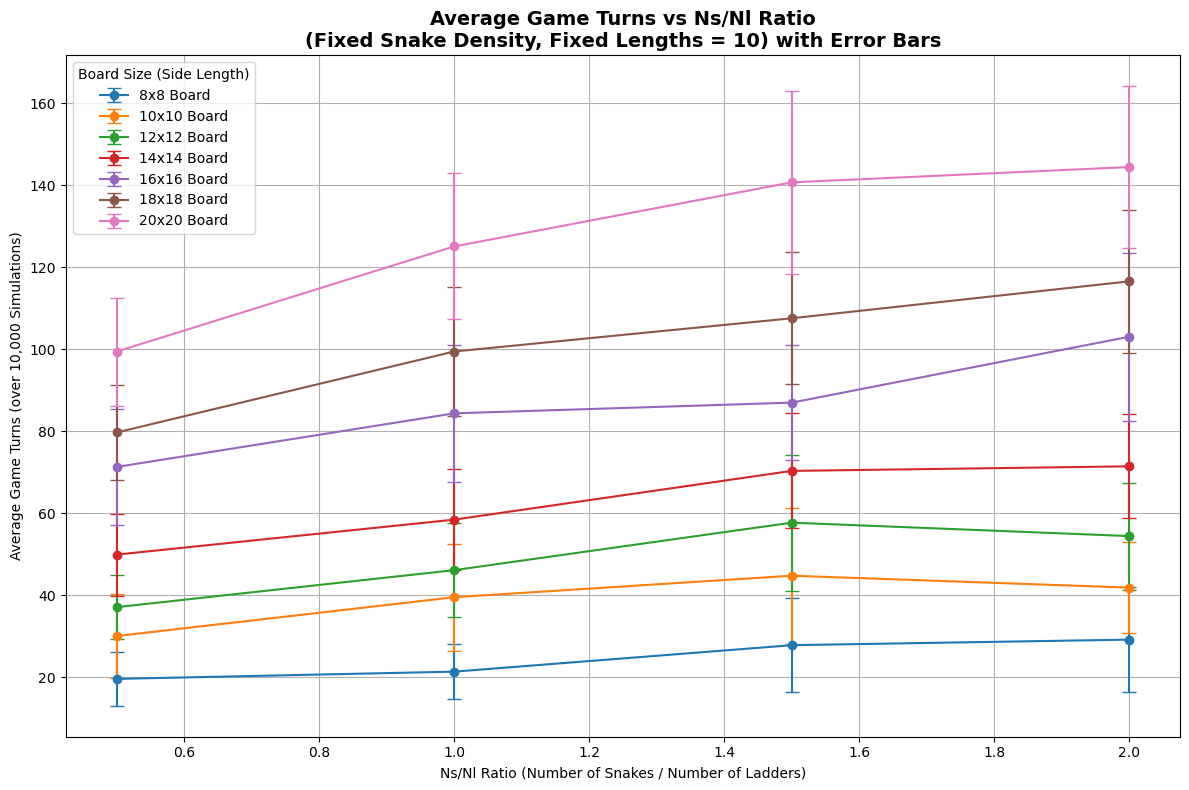

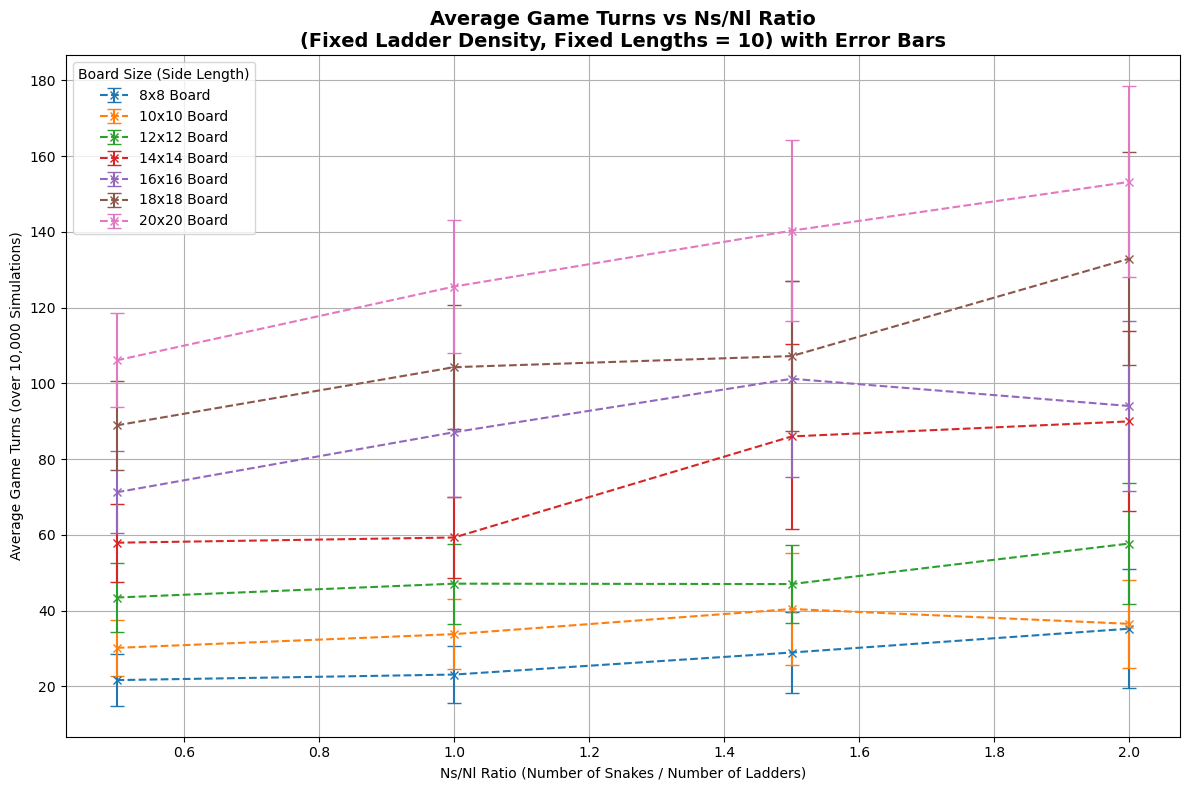

In [120]:
# Cell 16: Call plot_avg_turns_vs_ratio_with_errorbars to generate the plot

plot_avg_turns_vs_ratio_with_errorbars(results_df)


In [121]:
# Cell 18 (Revised - with Plot Saving): Function to Plot Win Probability vs Board Size, Separated by Ns/Nl Ratio - Now Saving for All Ratios

def plot_win_prob_vs_board_size_by_ratio(results_df):
    """
    Generates plots of Win Probability (BoardSize/2, BoardSize/3, BoardSize/4 turns) vs Board Size,
    separated by Ns/Nl ratio, for both Fixed Snake and Fixed Ladder Density.
    Now SAVES plots to files for ALL Ns/Nl ratios.
    Updated labels to show BoardSize/X and use Ns/Nl in legend.
    """
    for ratio in NS_NL_RATIOS:  # Iterate through each Ns/Nl ratio
        plt.figure(figsize=(12, 8)) # Create figure for saving

        # --- Data for Fixed Snake Density ---
        snake_df_ratio = results_df[(results_df['simulation_type'] == "fixed_snake_density") &
                                    (results_df['ns_nl_ratio'] == ratio)]
        # Sort by board size for line plot
        snake_df_ratio = snake_df_ratio.sort_values(by='board_size')

        # Plot Win Probabilities vs Board Size (Fixed Snake Density)
        plt.plot(snake_df_ratio['board_size'], snake_df_ratio['prob_win_half_turns'],
                 marker='o', linestyle='-', label='P(Win BoardSize/2 Turns, $N_s$ Fixed)')
        plt.plot(snake_df_ratio['board_size'], snake_df_ratio['prob_win_third_turns'],
                 marker='s', linestyle='-', label='P(Win BoardSize/3 Turns, $N_s$ Fixed)')
        plt.plot(snake_df_ratio['board_size'], snake_df_ratio['prob_win_quarter_turns'],
                 marker='^', linestyle='-', label='P(Win BoardSize/4 Turns, $N_s$ Fixed)')

        # --- Data for Fixed Ladder Density ---
        ladder_df_ratio = results_df[(results_df['simulation_type'] == "fixed_ladder_density") &
                                     (results_df['ns_nl_ratio'] == ratio)]
        # Sort by board size
        ladder_df_ratio = ladder_df_ratio.sort_values(by='board_size')

        # Plot Win Probabilities vs Board Size (Fixed Ladder Density)
        plt.plot(ladder_df_ratio['board_size'], ladder_df_ratio['prob_win_half_turns'],
                 marker='x', linestyle='--', label='P(Win BoardSize/2 Turns, $N_l$ Fixed)')
        plt.plot(ladder_df_ratio['board_size'], ladder_df_ratio['prob_win_third_turns'],
                 marker='D', linestyle='--', label='P(Win BoardSize/3 Turns, $N_l$ Fixed)')
        plt.plot(ladder_df_ratio['board_size'], ladder_df_ratio['prob_win_quarter_turns'],
                 marker='P', linestyle='--', label='P(Win BoardSize/4 Turns, $N_l$ Fixed)')


        plt.xlabel("Board Size (Number of Tiles)")
        plt.ylabel("Probability of Winning within BoardSize Turns")
        ratio_str = str(ratio).replace(".", "_")  # Format ratio for title
        plot_title = f"Win Probability vs Board Size (Ns/Nl Ratio = {ratio})"
        plt.title(plot_title, fontsize=14, fontweight='bold')
        plt.legend(title="Win Probability & Density Type")
        plt.grid(True)
        plt.tight_layout()

        # --- SAVE PLOT (Win Probability vs Board Size, By Ratio) ---
        plot_params_win_prob_boardsize_ratio = {"ns_nl_ratio": ratio} # Parameters for filename
        save_plot(plt, "WinProbVsBoardSize_ByRatio", plot_params_win_prob_boardsize_ratio) # Call save_plot


    plt.show() # Keep plt.show() OUTSIDE loop


Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-0_5.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-1_0.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-1_5.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-2_0.png


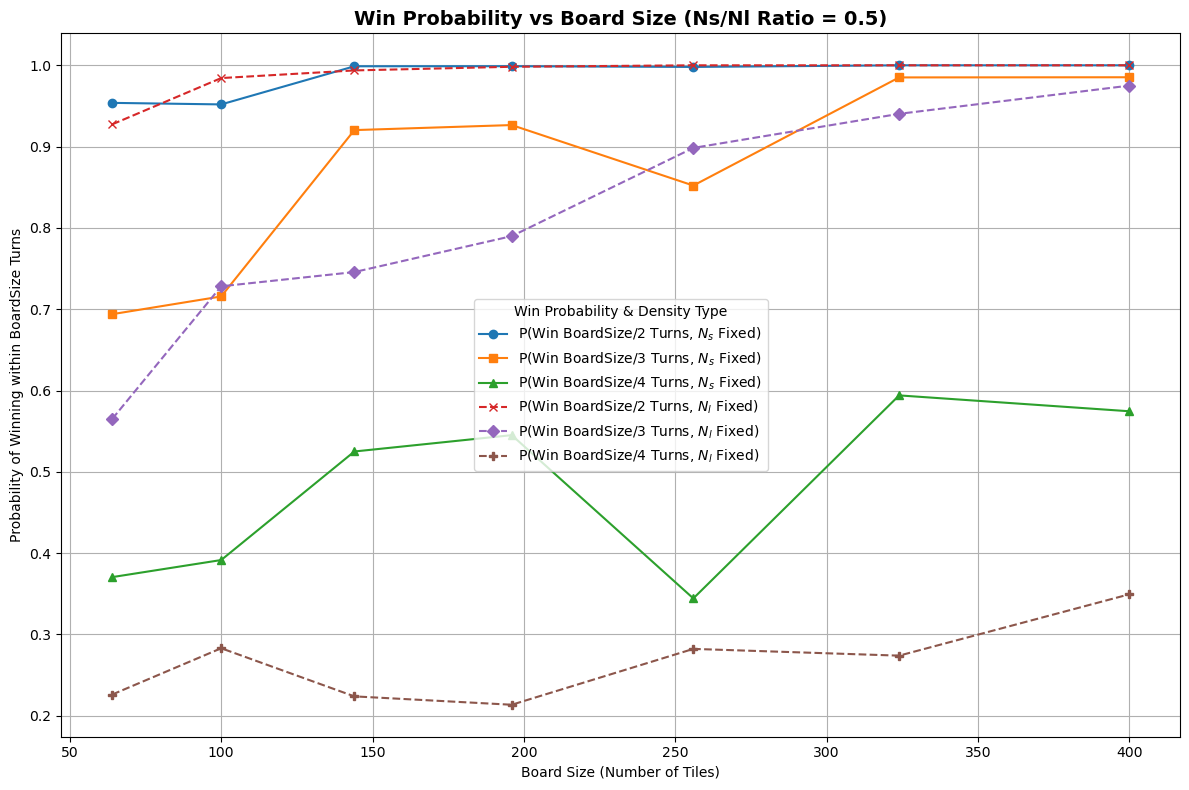

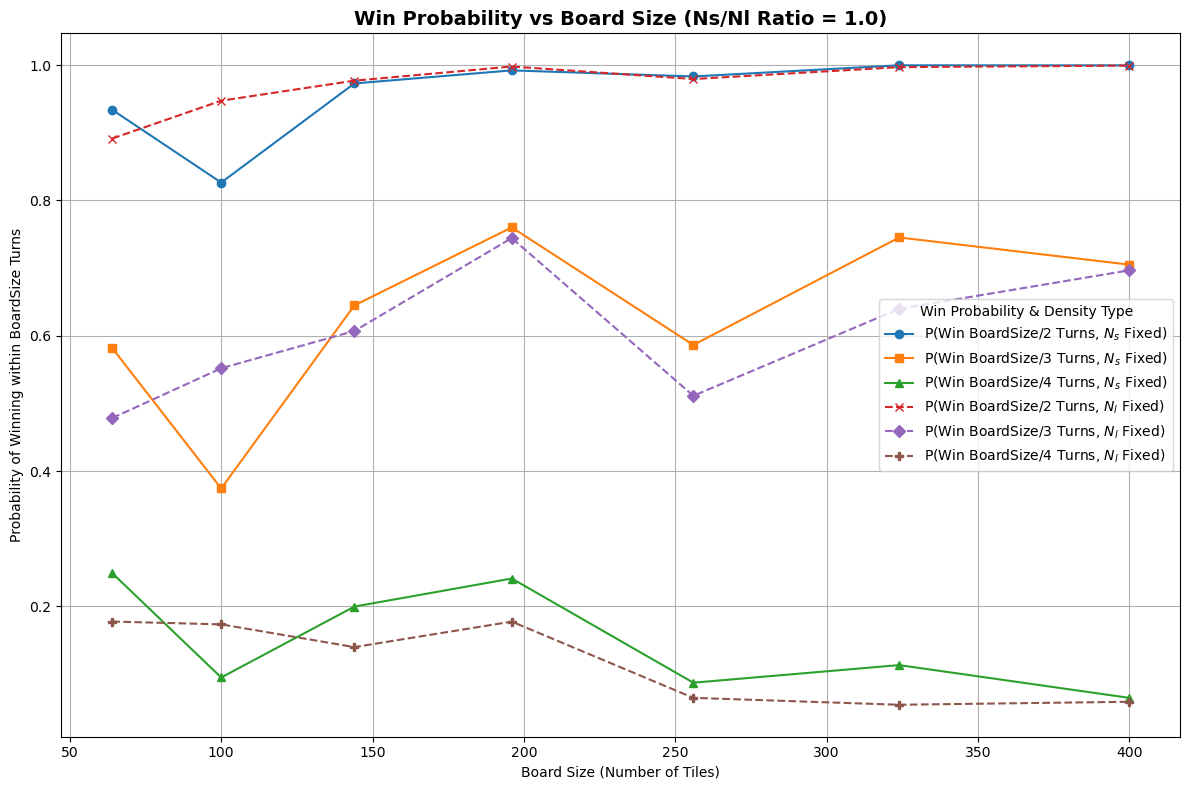

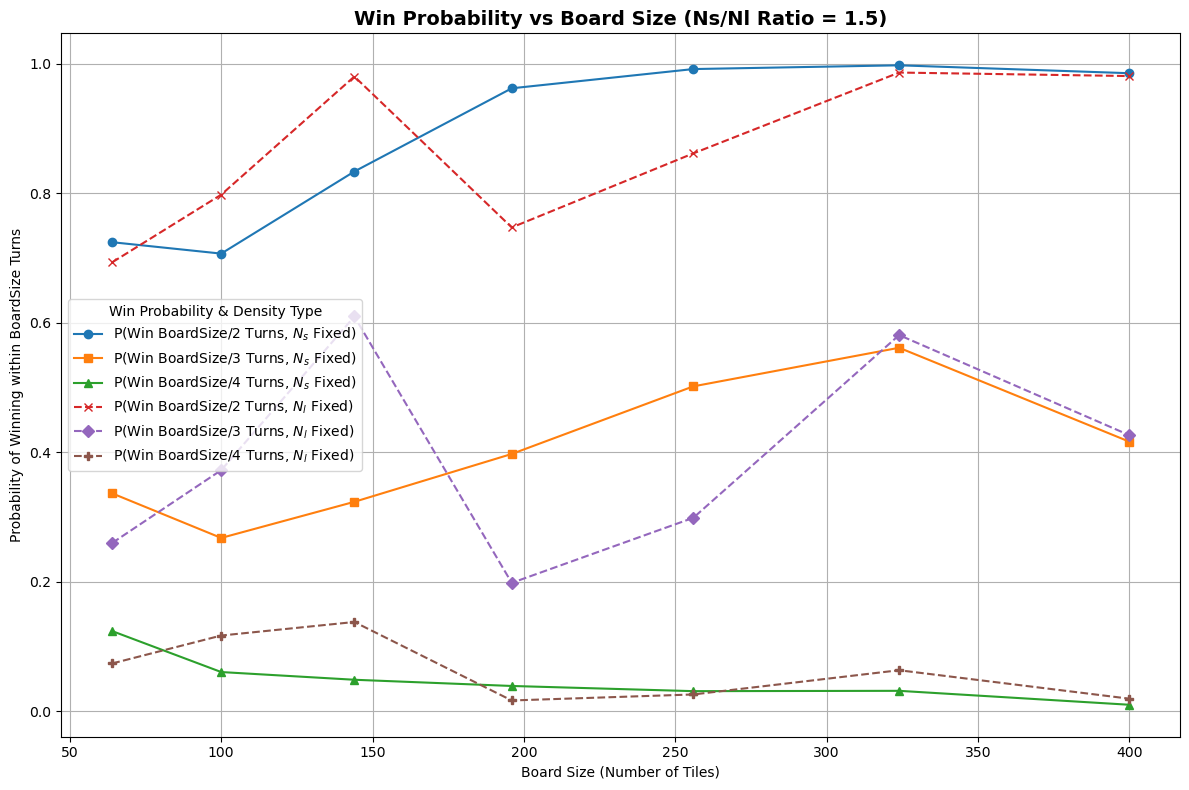

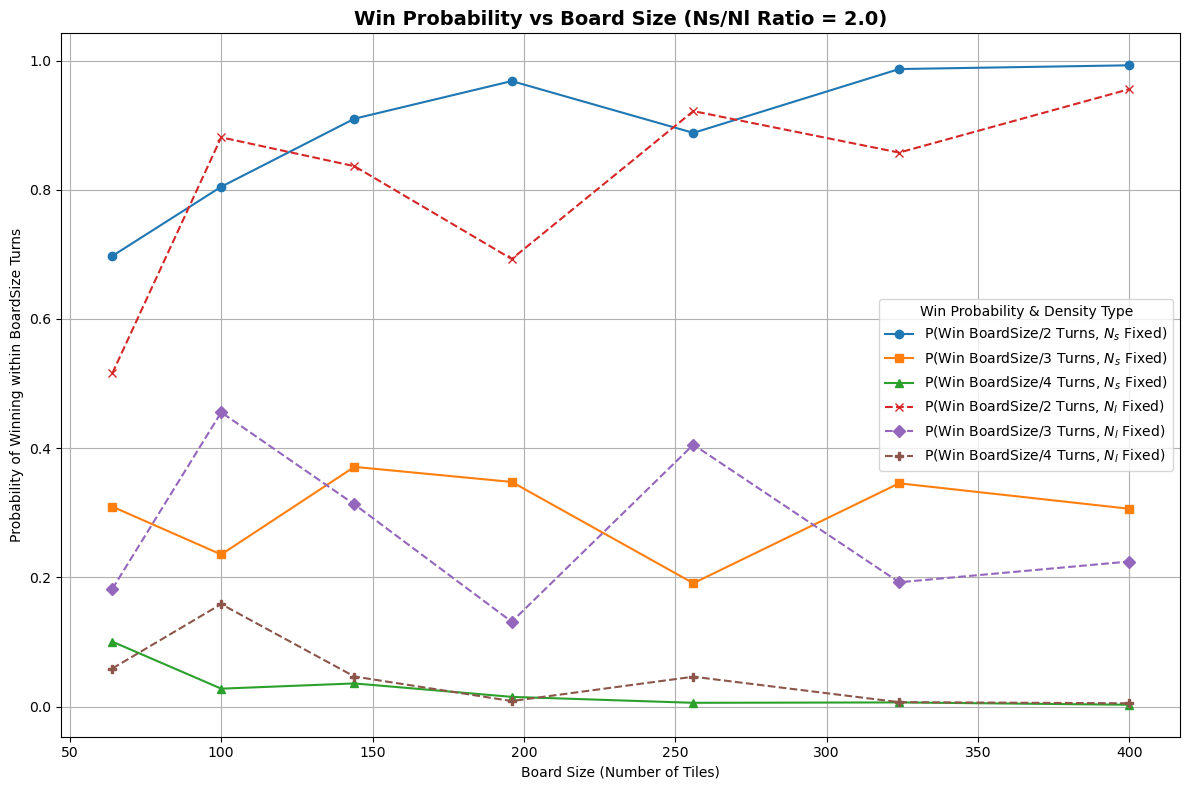

In [122]:
# Cell 18: Call plot_win_prob_vs_board_size_by_ratio to generate plots

plot_win_prob_vs_board_size_by_ratio(results_df)


In [123]:
def plot_win_probability_vs_ratio_combined(results_df, simulation_type):
    """
    Plot win probabilities against Ns/Nl ratio for all board sizes combined.
    Now SAVES plots to files as well.
    Updated labels to show BoardSize/X and use Ns/Nl in title.
    """
    # Filter data for the simulation type
    filtered_df = results_df[results_df['simulation_type'] == simulation_type]

    # Create figure for each probability type
    for prob_type, prob_label in [
        ('prob_win_half_turns', 'BoardSize/2'),
        ('prob_win_third_turns', 'BoardSize/3'),
        ('prob_win_quarter_turns', 'BoardSize/4')
    ]:
        plt.figure(figsize=(12, 8)) # Create figure for saving

        for board_size in BOARD_SIZES:
            board_df = filtered_df[filtered_df['board_size'] == board_size]
            square_side = int(np.sqrt(board_size))
            plt.plot(board_df['ns_nl_ratio'], board_df[prob_type],
                     marker='o', linestyle='-', label=f'{square_side}x{square_side} Board')

        sim_type_label = f"Fixed $N_s$ Density (0.1)" if simulation_type == "fixed_snake_density" else f"Fixed $N_l$ Density (0.1)"

        plt.xlabel("Ns/Nl Ratio")
        plt.ylabel(f"P(Win within {prob_label} Turns)")
        plot_title = f"Win Probability within {prob_label} Turns vs Ns/Nl Ratio\n({sim_type_label})" # Enhanced plot title
        plt.title(plot_title, fontsize=14, fontweight='bold') # More prominent title
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # --- SAVE PLOT (Win Probability vs Ratio Combined) ---
        plot_params_win_prob_combined = {"prob_type": prob_type, "simulation_type": simulation_type} # Parameters for filename
        save_plot(plt, "WinProbVsRatio_Combined", plot_params_win_prob_combined) # Call save_plot


    plt.show() # Keep plt.show() OUTSIDE loops

Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_half_turns_simulation_type-fixed_snake_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_third_turns_simulation_type-fixed_snake_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_quarter_turns_simulation_type-fixed_snake_density.png


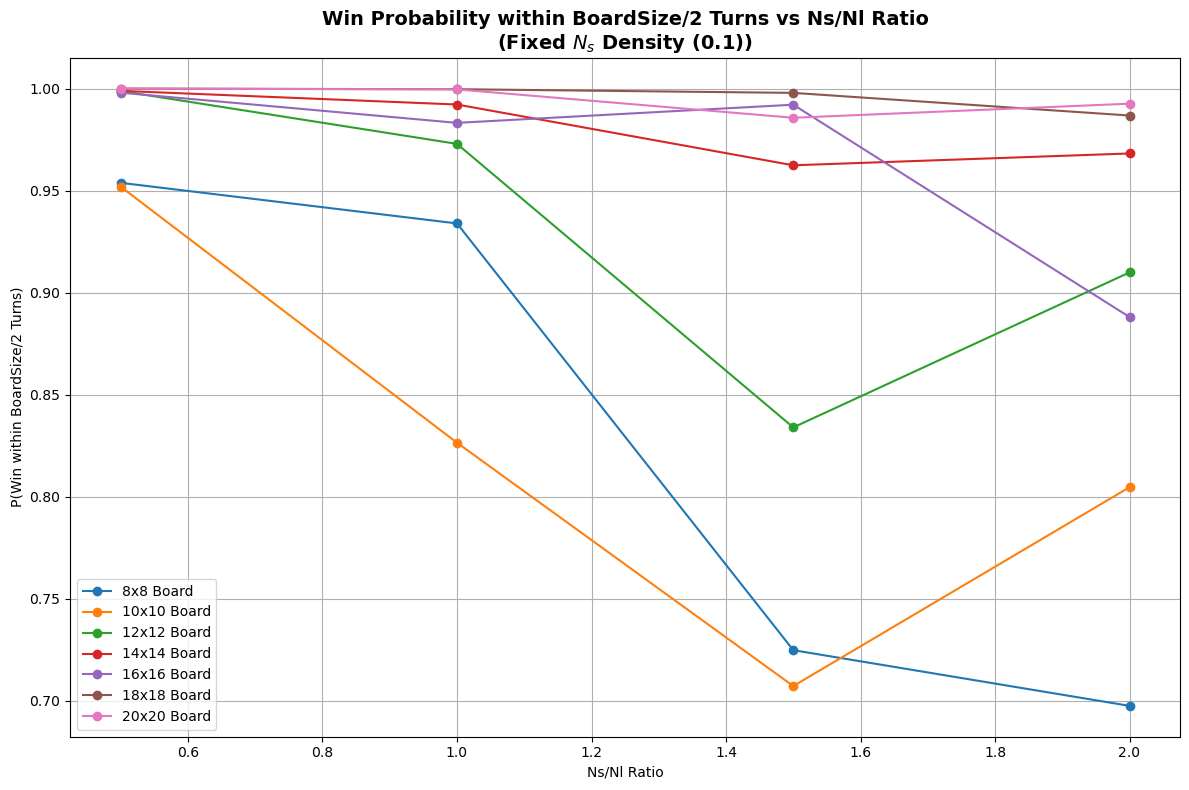

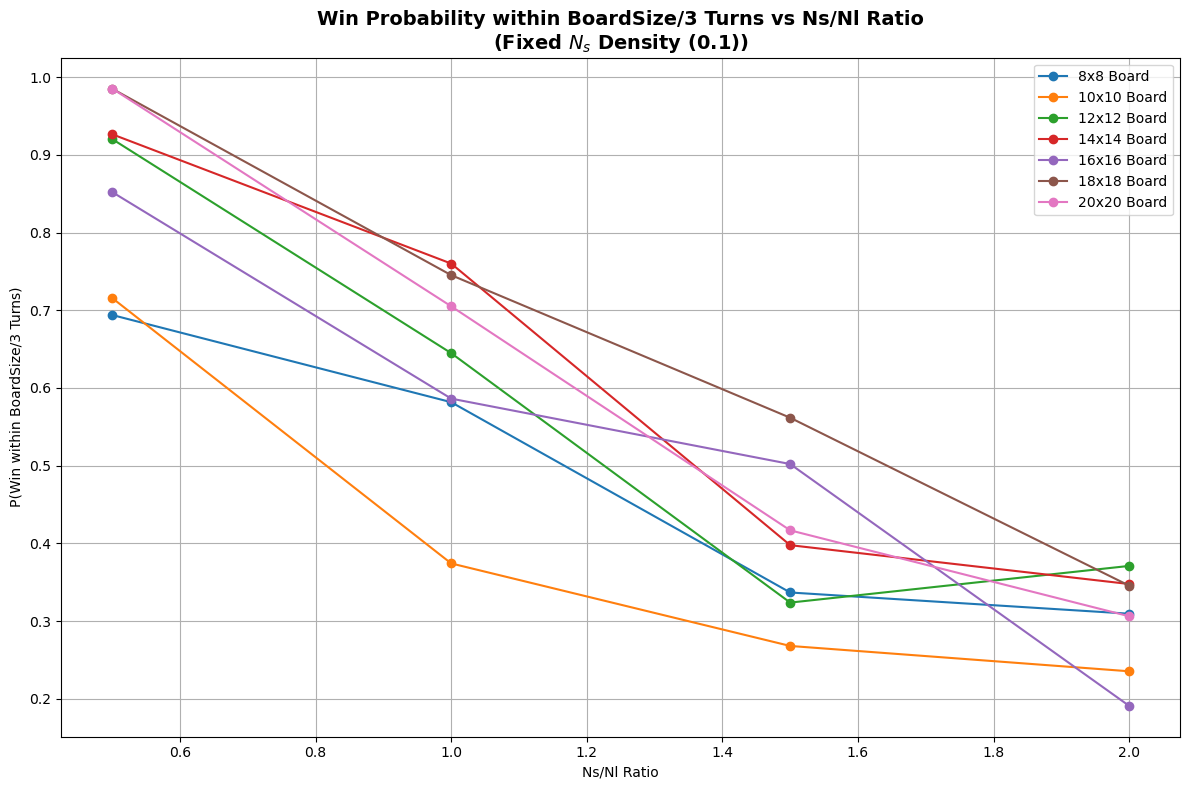

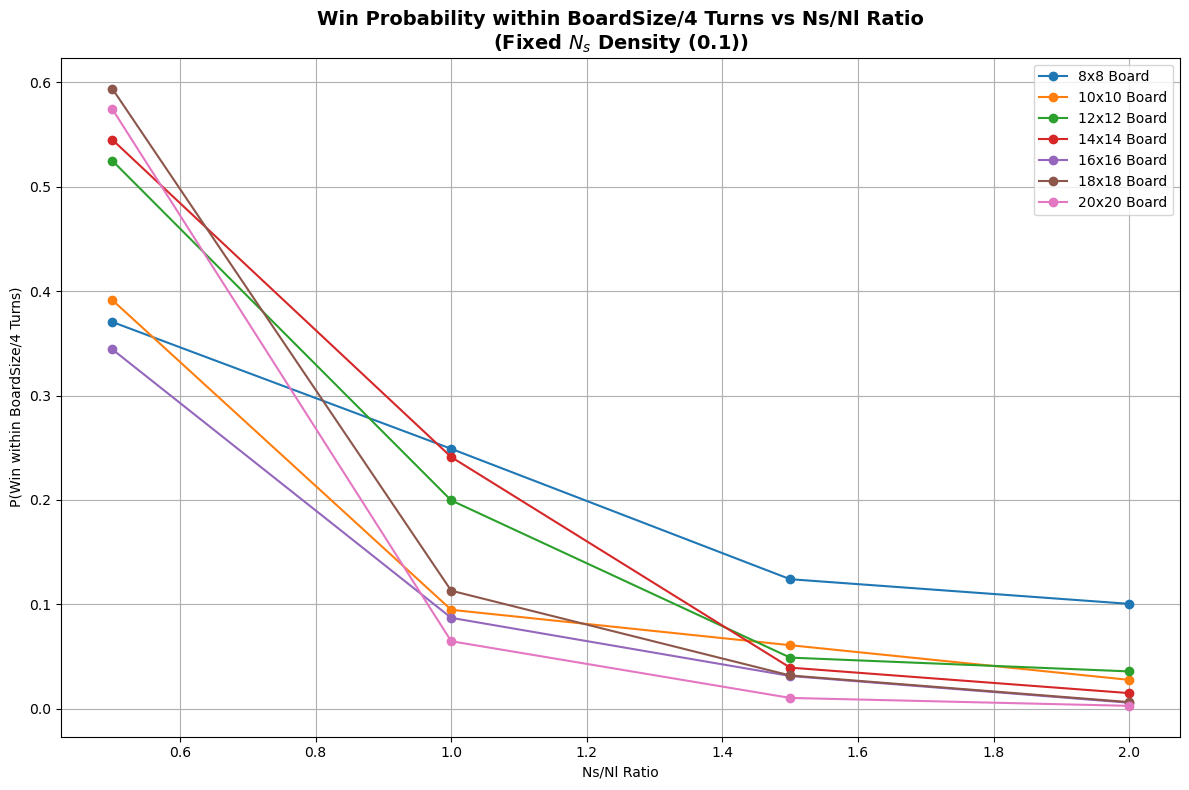

Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_half_turns_simulation_type-fixed_ladder_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_third_turns_simulation_type-fixed_ladder_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_quarter_turns_simulation_type-fixed_ladder_density.png


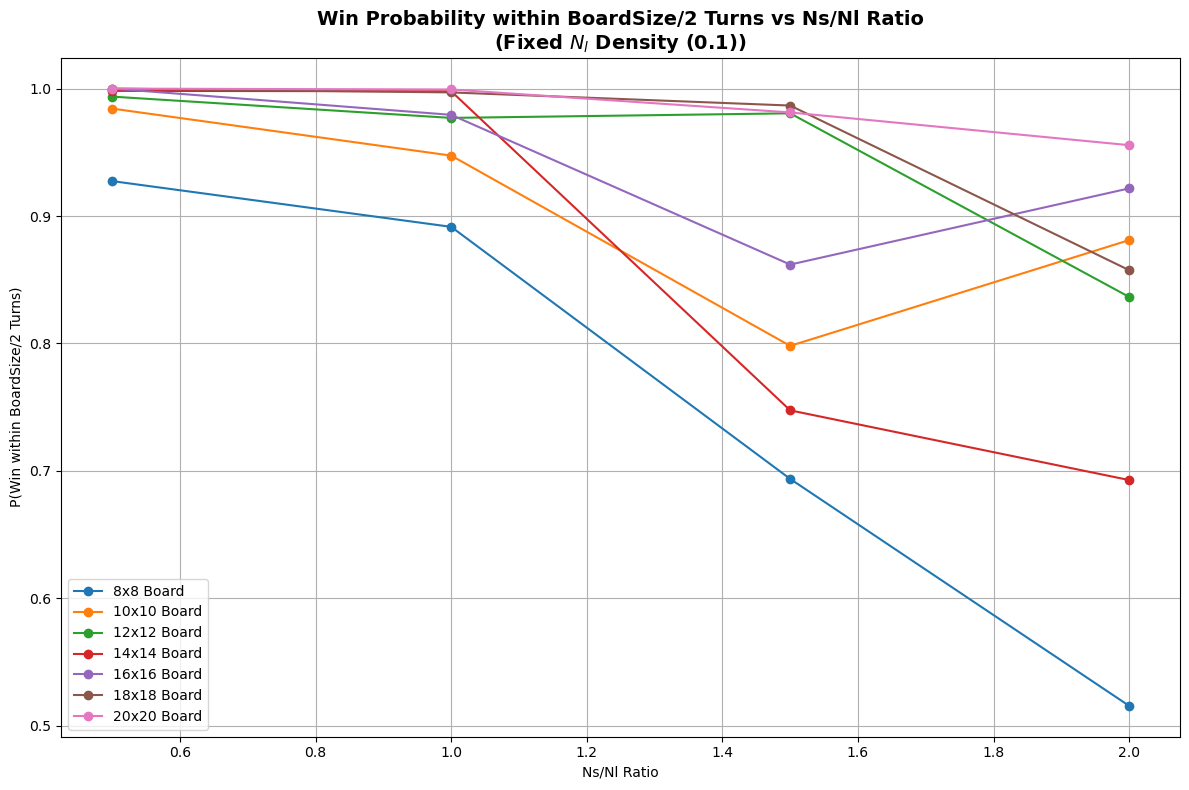

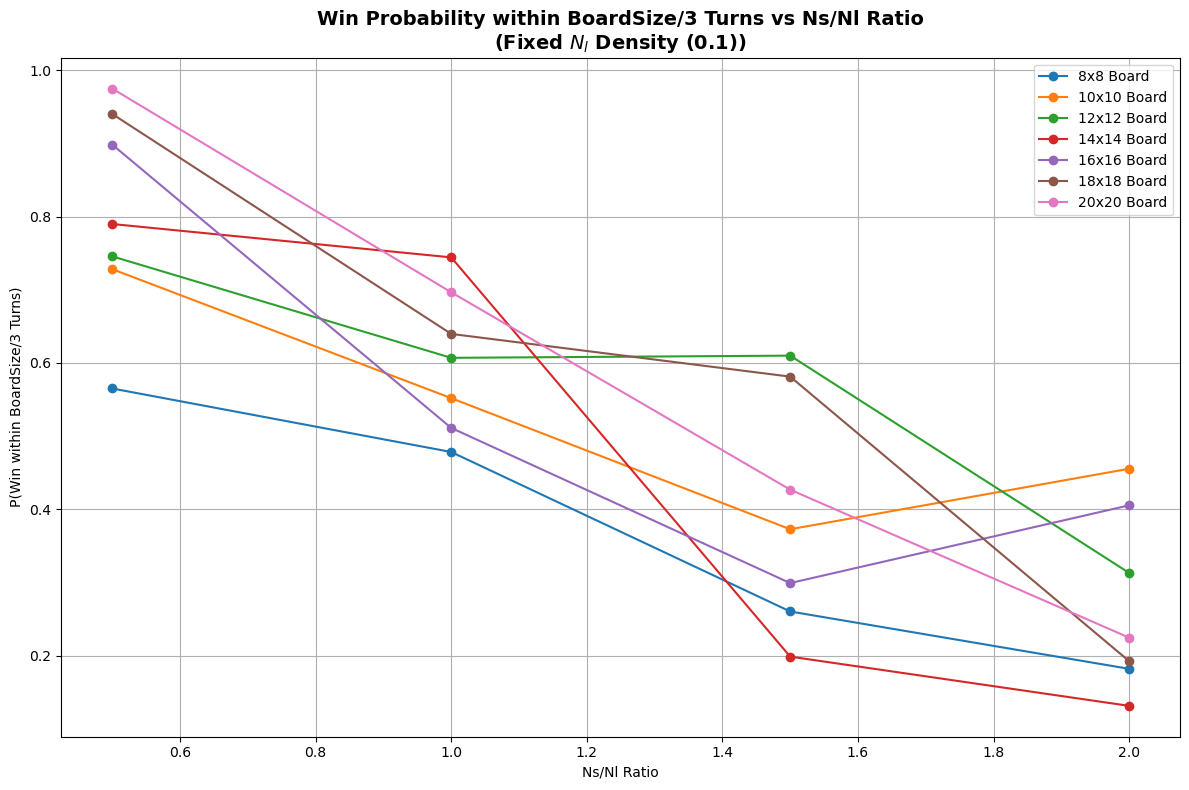

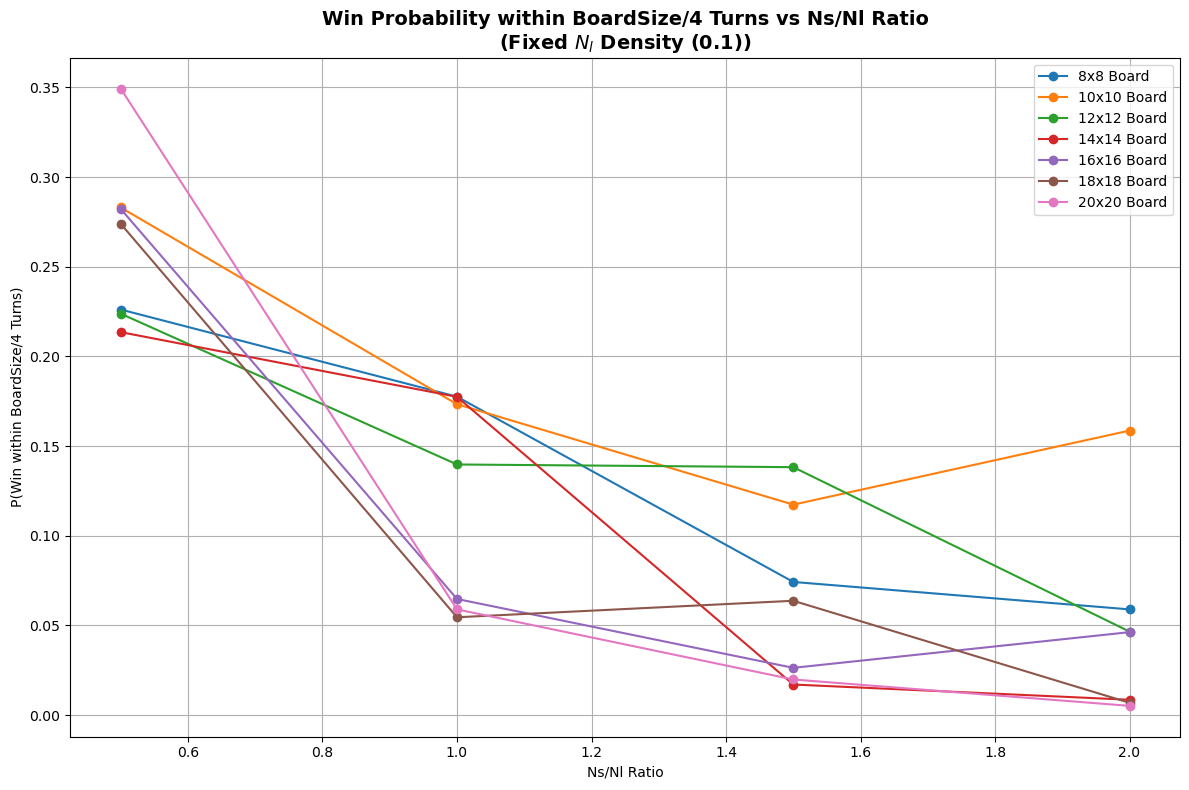

In [124]:
plot_win_probability_vs_ratio_combined(results_df, "fixed_snake_density") # Example call for fixed_snake_density
plot_win_probability_vs_ratio_combined(results_df, "fixed_ladder_density") # Example call for fixed_ladder_density


In [126]:
def plot_win_prob_vs_board_size_ratio_one(results_df):
    """
    Generates plots of Win Probability vs Board Size,
    SPECIFICALLY for Ns/Nl Ratio = 1.0, for both Fixed Snake and Fixed Ladder Density.
    Enhanced plot titles and labels now include more parameter info and BoardSize/X labels.
    Now SAVES plot to file as well.
    """
    plt.figure(figsize=(12, 8))

    # --- Data for Fixed Snake Density (Ns/Nl Ratio = 1.0) ---
    snake_df_ratio_one = results_df[(results_df['simulation_type'] == "fixed_snake_density") &
                                        (results_df['ns_nl_ratio'] == 1.0)]
    # Sort by board size for line plot
    snake_df_ratio_one = snake_df_ratio_one.sort_values(by='board_size')

    # Plot Win Probabilities vs Board Size (Fixed Snake Density, Ns/Nl = 1.0)
    plt.plot(snake_df_ratio_one['board_size'], snake_df_ratio_one['prob_win_half_turns'],
             marker='o', linestyle='-', label='P(Win BoardSize/2 Turns, $N_s$ Fixed)')
    plt.plot(snake_df_ratio_one['board_size'], snake_df_ratio_one['prob_win_third_turns'],
             marker='s', linestyle='-', label='P(Win BoardSize/3 Turns, $N_s$ Fixed)')
    plt.plot(snake_df_ratio_one['board_size'], snake_df_ratio_one['prob_win_quarter_turns'],
             marker='^', linestyle='-', label='P(Win BoardSize/4 Turns, $N_s$ Fixed)')


    # --- Data for Fixed Ladder Density (Ns/Nl Ratio = 1.0) ---
    ladder_df_ratio_one = results_df[(results_df['simulation_type'] == "fixed_ladder_density") &
                                         (results_df['ns_nl_ratio'] == 1.0)]
    # Sort by board size
    ladder_df_ratio_one = ladder_df_ratio_one.sort_values(by='board_size')

    # Plot Win Probabilities vs Board Size (Fixed Ladder Density, Ns/Nl = 1.0)
    plt.plot(ladder_df_ratio_one['board_size'], ladder_df_ratio_one['prob_win_half_turns'],
             marker='x', linestyle='--', label='P(Win BoardSize/2 Turns, $N_l$ Fixed)')
    plt.plot(ladder_df_ratio_one['board_size'], ladder_df_ratio_one['prob_win_third_turns'],
             marker='D', linestyle='--', label='P(Win BoardSize/3 Turns, $N_l$ Fixed)')
    plt.plot(ladder_df_ratio_one['board_size'], ladder_df_ratio_one['prob_win_quarter_turns'],
             marker='P', linestyle='--', label='P(Win BoardSize/4 Turns, $N_l$ Fixed)')


    plot_title = f"Win Probability vs Board Size\n(Ns/Nl Ratio = 1.0, Fixed Lengths = {FIXED_SNAKE_LADDER_LENGTH})" # Enhanced plot title
    plt.xlabel("Board Size (Number of Tiles)")
    plt.ylabel("Probability of Winning within BoardSize Turns (over 10,000 Simulations)") # Enhanced y-axis label
    plt.title(plot_title, fontsize=14, fontweight='bold') # More prominent title
    plt.legend(title="Win Probability & Density Type", fontsize='medium')
    plt.grid(True)
    plt.tight_layout()

    # --- SAVE PLOT (Win Probability vs Board Size Ratio One) ---
    plot_params_win_prob_ratio_one = {"ns_nl_ratio": 1.0} # Parameters for filename - ratio is fixed at 1.0
    save_plot(plt, "WinProbVsBoardSize_RatioOne", plot_params_win_prob_ratio_one) # Call save_plot
    plt.show()


Plot saved to: plots_output/WinProbVsBoardSize_RatioOne/WinProbVsBoardSize_RatioOne_ns_nl_ratio-1_0.png


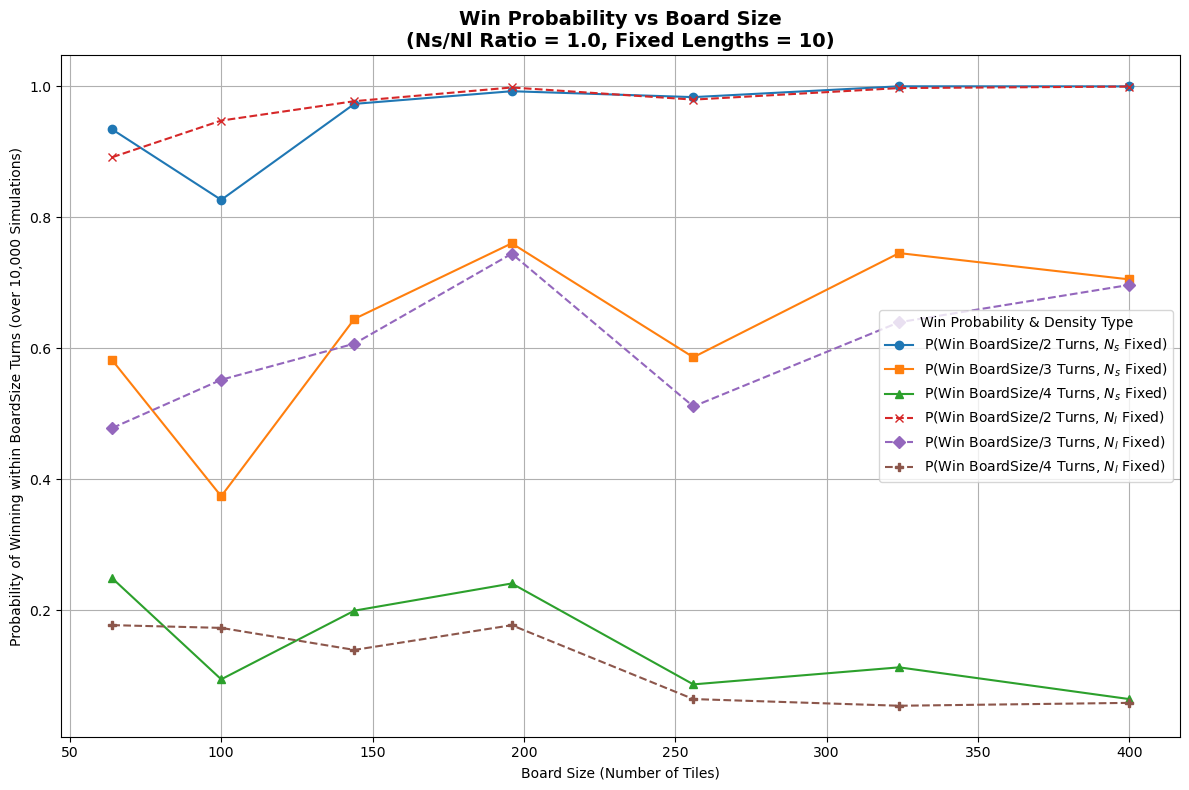

In [127]:
# Cell 21: Call plot_win_prob_vs_board_size_ratio_one to generate the plot

plot_win_prob_vs_board_size_ratio_one(results_df)


In [128]:
# Cell 22 (Revised - with Plot Saving): Function to Plot Average Turns vs Board Size, Separated by Ns/Nl Ratio - Now Saving for All Ratios

def plot_avg_turns_vs_board_size_by_ratio(results_df):
    """
    Generates plots of Average Game Turns vs Board Size, separated by Ns/Nl ratio,
    for both Fixed Snake and Fixed Ladder Density. Now SAVES plots to files for ALL ratios.
    """
    for ratio in NS_NL_RATIOS:  # Iterate through each Ns/Nl ratio
        plt.figure(figsize=(12, 8)) # Create figure for saving

        # --- Data for Fixed Snake Density ---
        snake_df_ratio = results_df[(results_df['simulation_type'] == "fixed_snake_density") &
                                    (results_df['ns_nl_ratio'] == ratio)]
        # Sort by board size for line plot
        snake_df_ratio = snake_df_ratio.sort_values(by='board_size')

        # Plot Average Turns vs Board Size (Fixed Snake Density)
        plt.plot(snake_df_ratio['board_size'], snake_df_ratio['average_turns'],
                 marker='o', linestyle='-', label='Average Turns (Snakes Fixed)')


        # --- Data for Fixed Ladder Density ---
        ladder_df_ratio = results_df[(results_df['simulation_type'] == "fixed_ladder_density") &
                                     (results_df['ns_nl_ratio'] == ratio)]
        # Sort by board size
        ladder_df_ratio = ladder_df_ratio.sort_values(by='board_size')

        # Plot Average Turns vs Board Size (Fixed Ladder Density)
        plt.plot(ladder_df_ratio['board_size'], ladder_df_ratio['average_turns'],
                 marker='x', linestyle='--', label='Average Turns (Ladders Fixed)')


        plt.xlabel("Board Size (Number of Tiles)")
        plt.ylabel("Average Game Turns")
        ratio_str = str(ratio).replace(".", "_")  # Format ratio for title
        plot_title = f"Average Game Turns vs Board Size (Ns/Nl Ratio = {ratio})"
        plt.title(plot_title, fontsize=14, fontweight='bold')
        plt.legend(title="Density Type") # Updated legend title
        plt.grid(True)
        plt.tight_layout()

        # --- SAVE PLOT (Average Game Times vs Board Size, By Ratio) ---
        plot_params_avg_turns_boardsize_ratio = {"ns_nl_ratio": ratio} # Parameters for filename
        save_plot(plt, "AvgTurnsVsBoardSize_ByRatio", plot_params_avg_turns_boardsize_ratio) # Call save_plot

    plt.show() # Keep plt.show() OUTSIDE loop

Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-0_5.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-1_0.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-1_5.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-2_0.png


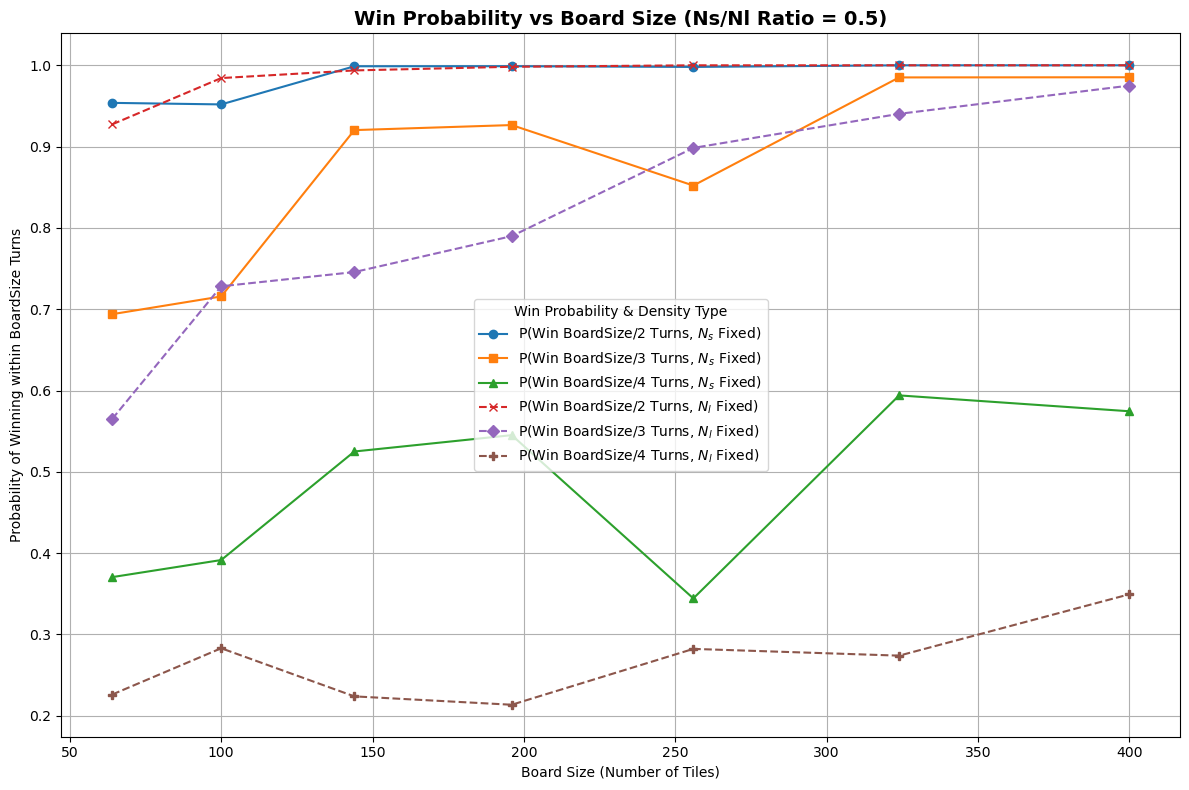

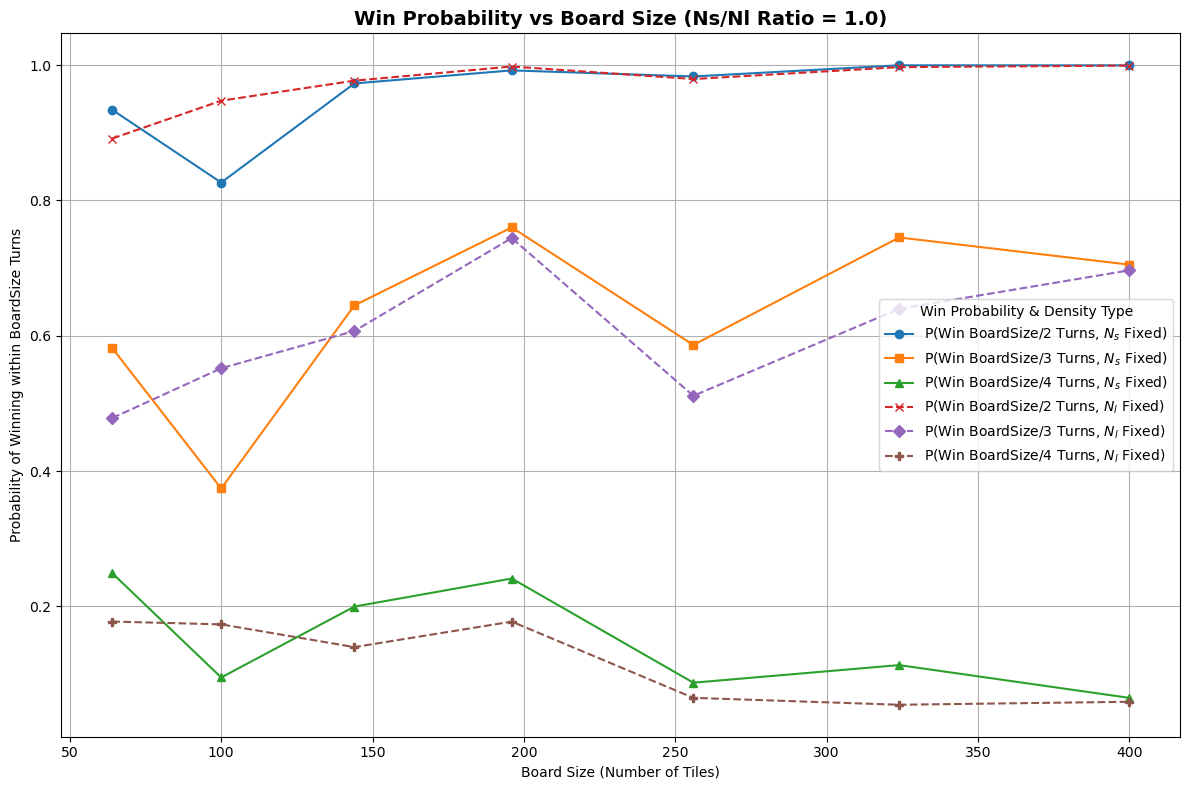

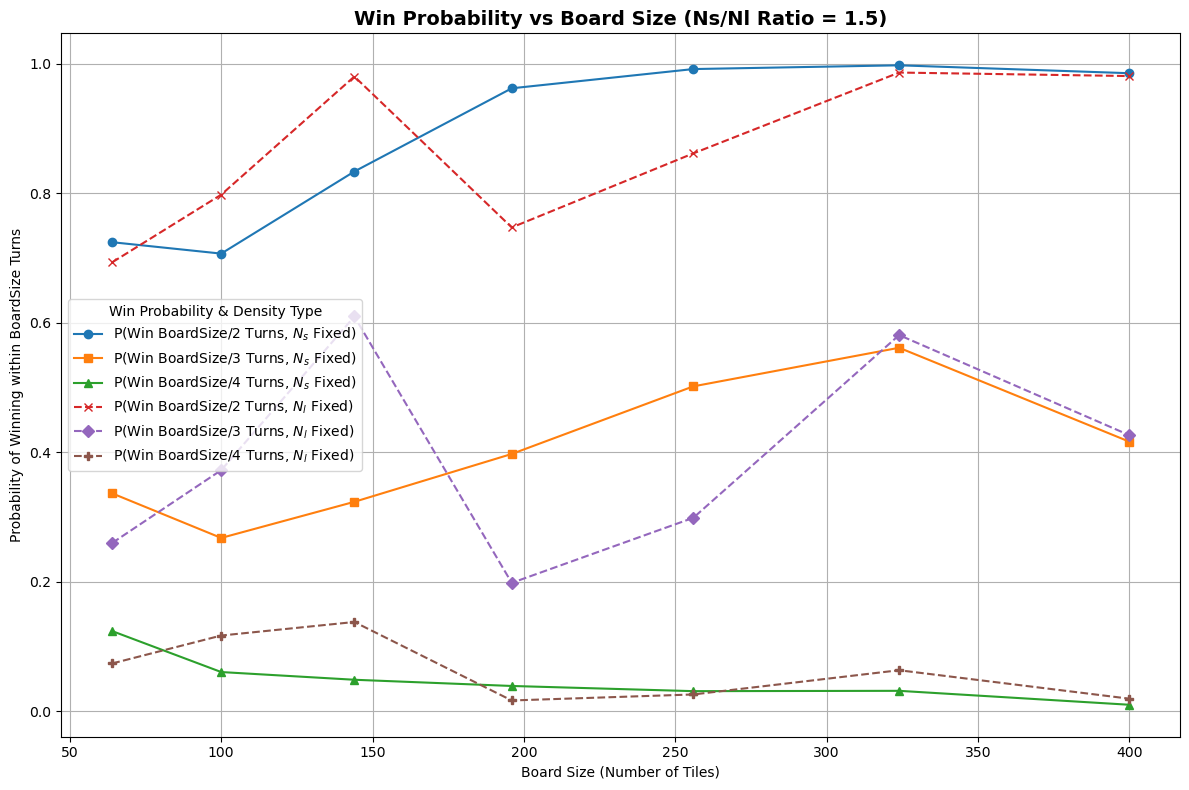

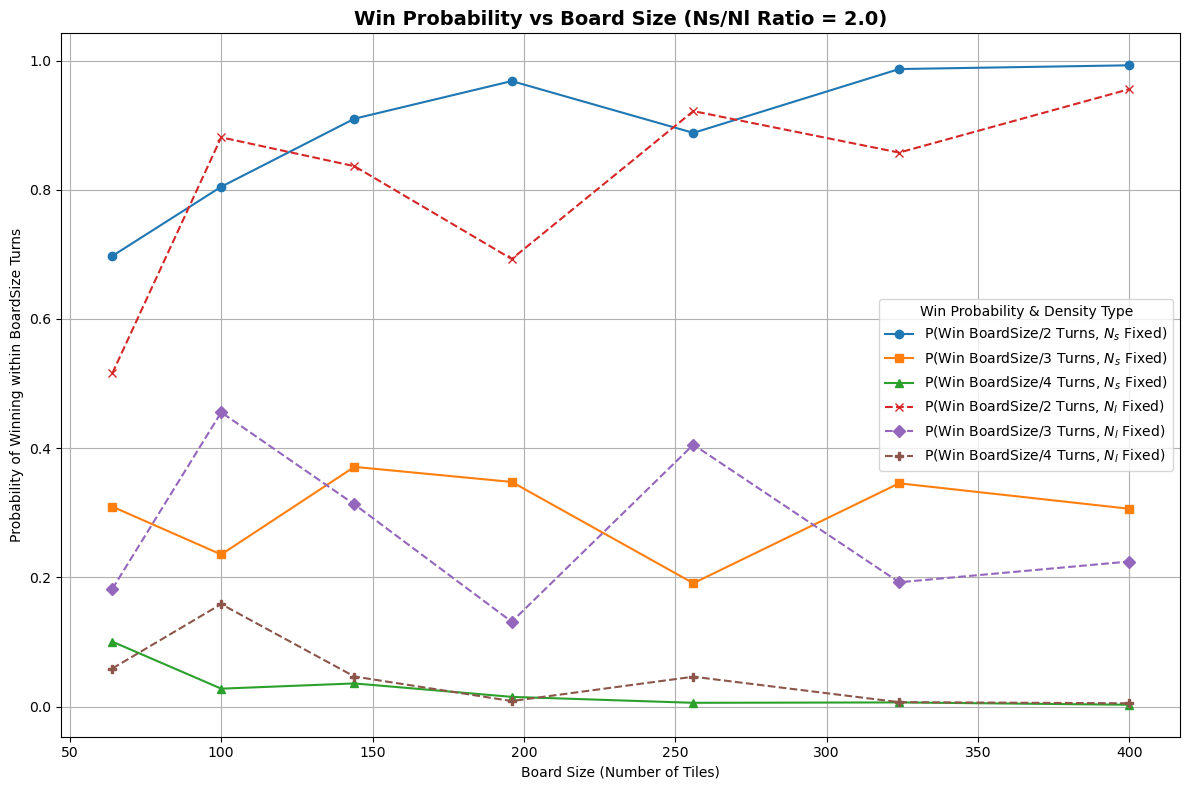

Plot saved to: plots_output/AvgTurnsVsBoardSize_ByRatio/AvgTurnsVsBoardSize_ByRatio_ns_nl_ratio-0_5.png
Plot saved to: plots_output/AvgTurnsVsBoardSize_ByRatio/AvgTurnsVsBoardSize_ByRatio_ns_nl_ratio-1_0.png
Plot saved to: plots_output/AvgTurnsVsBoardSize_ByRatio/AvgTurnsVsBoardSize_ByRatio_ns_nl_ratio-1_5.png
Plot saved to: plots_output/AvgTurnsVsBoardSize_ByRatio/AvgTurnsVsBoardSize_ByRatio_ns_nl_ratio-2_0.png


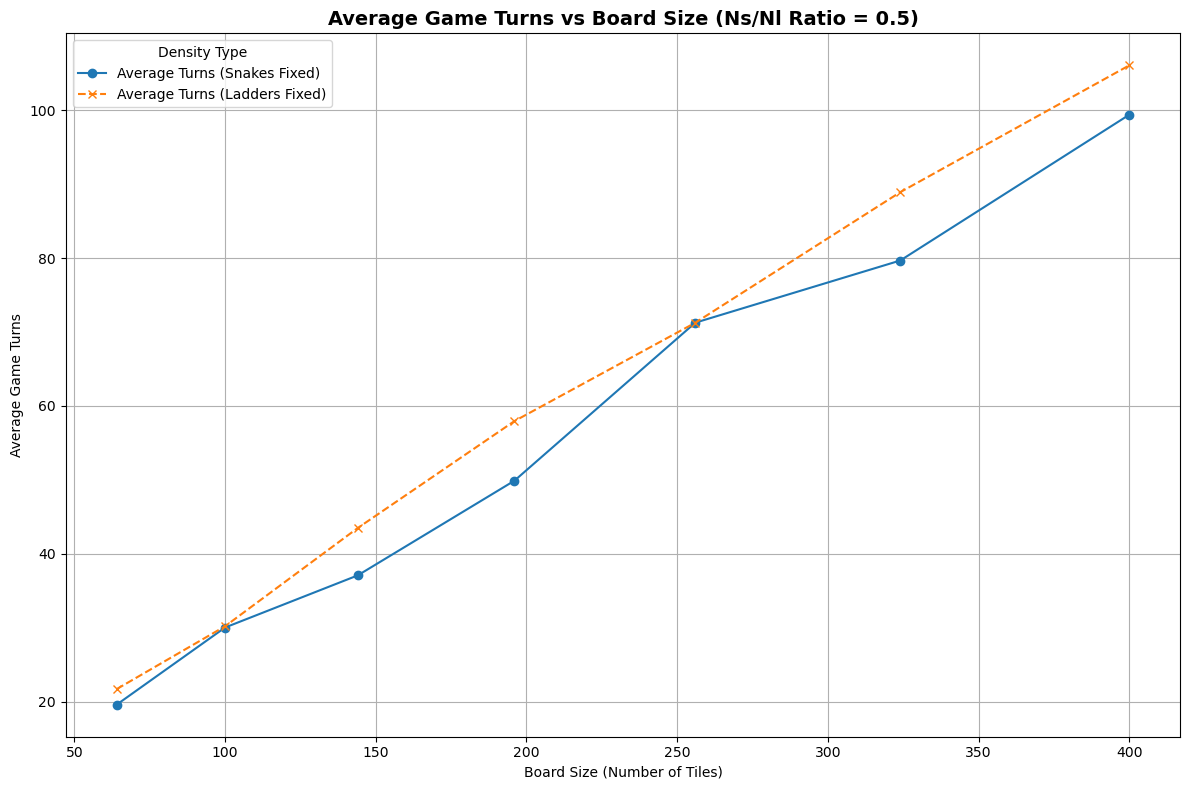

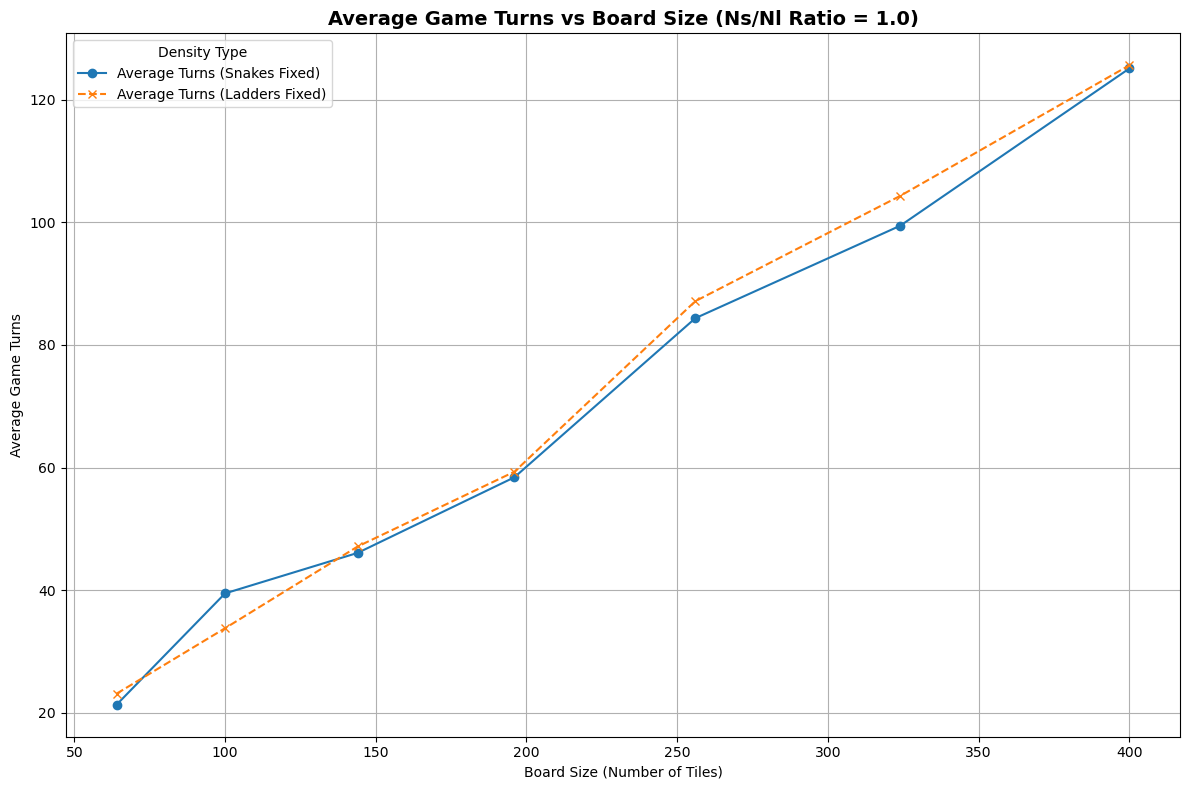

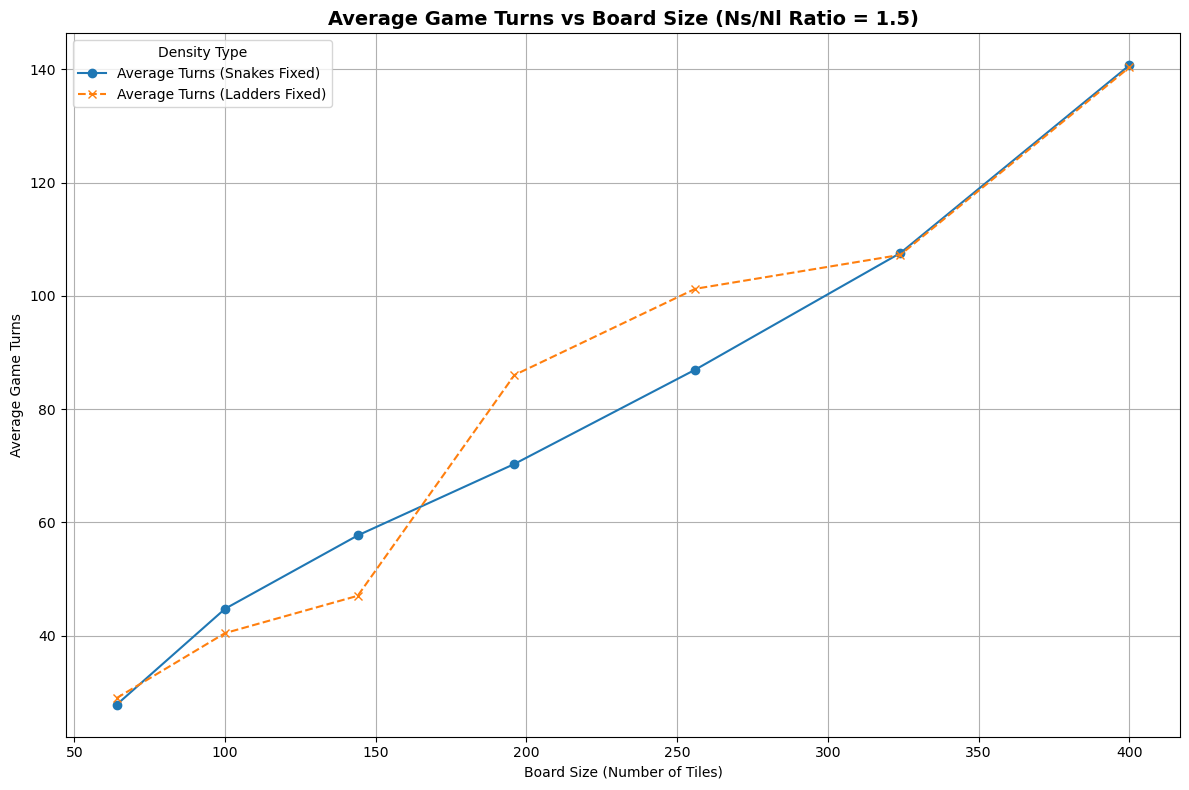

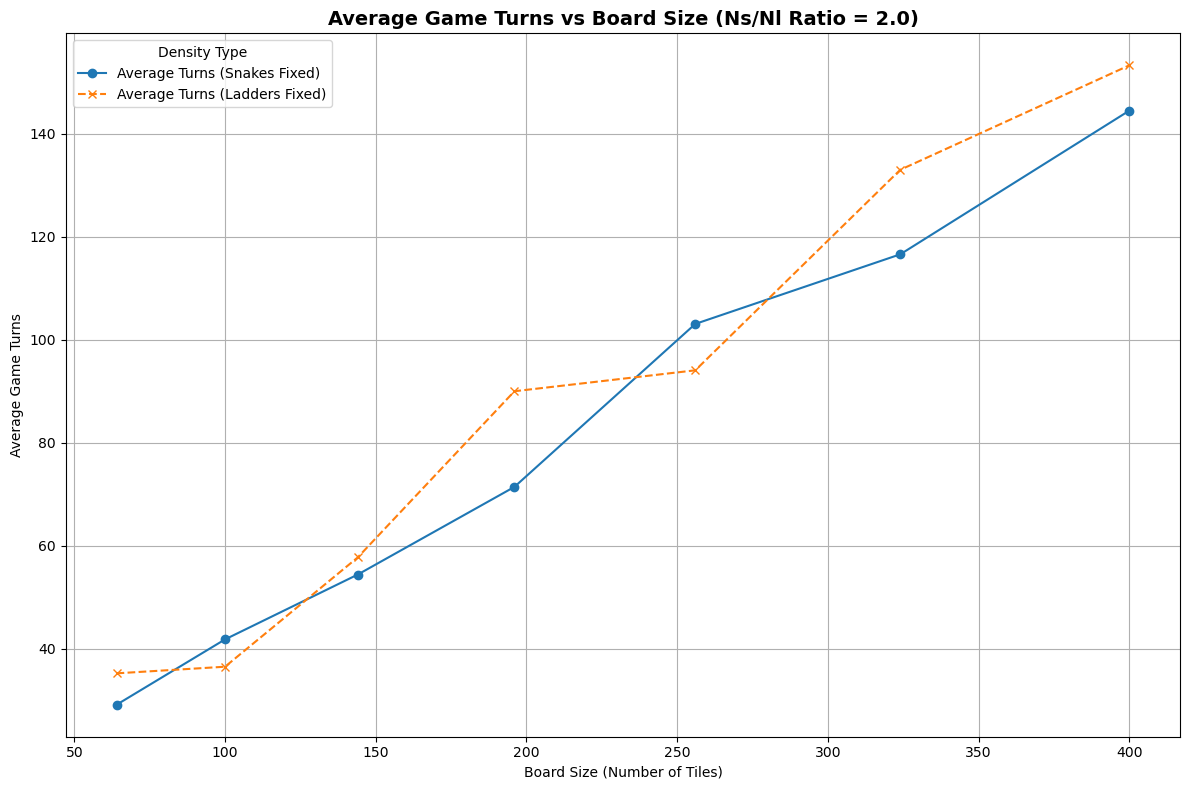

In [129]:
# Cell 18: Call plot_win_prob_vs_board_size_by_ratio to generate plots (Re-run)

plot_win_prob_vs_board_size_by_ratio(results_df)

# Cell 23: Call plot_avg_turns_vs_board_size_by_ratio to generate plots (Re-run)

plot_avg_turns_vs_board_size_by_ratio(results_df)

In [130]:
# Cell 24 (Revised - Enhanced Titles & Labels): Function to Plot Average Turns vs Board Size (Ns/Nl Ratio = 1.0 Specific)

def plot_avg_turns_vs_board_size_ratio_one(results_df):
    """
    Generates plots of Average Game Turns vs Board Size,
    SPECIFICALLY for Ns/Nl Ratio = 1.0, for both Fixed Snake and Fixed Ladder Density.
    Enhanced plot titles and labels now include more parameter info.
    Now SAVES plot to file as well.
    """
    plt.figure(figsize=(12, 8))

    # --- Data for Fixed Snake Density (Ns/Nl Ratio = 1.0) ---
    snake_df_ratio_one = results_df[(results_df['simulation_type'] == "fixed_snake_density") &
                                        (results_df['ns_nl_ratio'] == 1.0)]
    # Sort by board size for line plot
    snake_df_ratio_one = snake_df_ratio_one.sort_values(by='board_size')

    # Plot Average Turns vs Board Size (Fixed Snake Density, Ns/Nl = 1.0)
    plt.plot(snake_df_ratio_one['board_size'], snake_df_ratio_one['average_turns'],
             marker='o', linestyle='-', label='Average Turns (Snakes Fixed)')


    # --- Data for Fixed Ladder Density (Ns/Nl Ratio = 1.0) ---
    ladder_df_ratio_one = results_df[(results_df['simulation_type'] == "fixed_ladder_density") &
                                         (results_df['ns_nl_ratio'] == 1.0)]
    # Sort by board size
    ladder_df_ratio_one = ladder_df_ratio_one.sort_values(by='board_size')

    # Plot Average Turns vs Board Size (Fixed Ladder Density, Ns/Nl = 1.0)
    plt.plot(ladder_df_ratio_one['board_size'], ladder_df_ratio_one['average_turns'],
             marker='x', linestyle='--', label='Average Turns (Ladders Fixed)')


    plot_title = f"Average Game Turns vs Board Size\n(Ns/Nl Ratio = 1.0, Fixed Lengths = {FIXED_SNAKE_LADDER_LENGTH})" # Enhanced plot title
    plt.xlabel("Board Size (Number of Tiles)")
    plt.ylabel("Average Game Turns (over 10,000 Simulations)") # Enhanced y-axis label
    plt.title(plot_title, fontsize=14, fontweight='bold') # More prominent title
    plt.legend(title="Density Type", fontsize='medium')
    plt.grid(True)
    plt.tight_layout()

    # --- SAVE PLOT (Average Turns vs Board Size Ratio One) ---
    plot_params_avg_turns_ratio_one = {"ns_nl_ratio": 1.0} # Parameters for filename - ratio is fixed at 1.0
    save_plot(plt, "AvgTurnsVsBoardSize_RatioOne", plot_params_avg_turns_ratio_one) # Call save_plot
    plt.show()


Plot saved to: plots_output/AvgTurnsVsBoardSize_RatioOne/AvgTurnsVsBoardSize_RatioOne_ns_nl_ratio-1_0.png


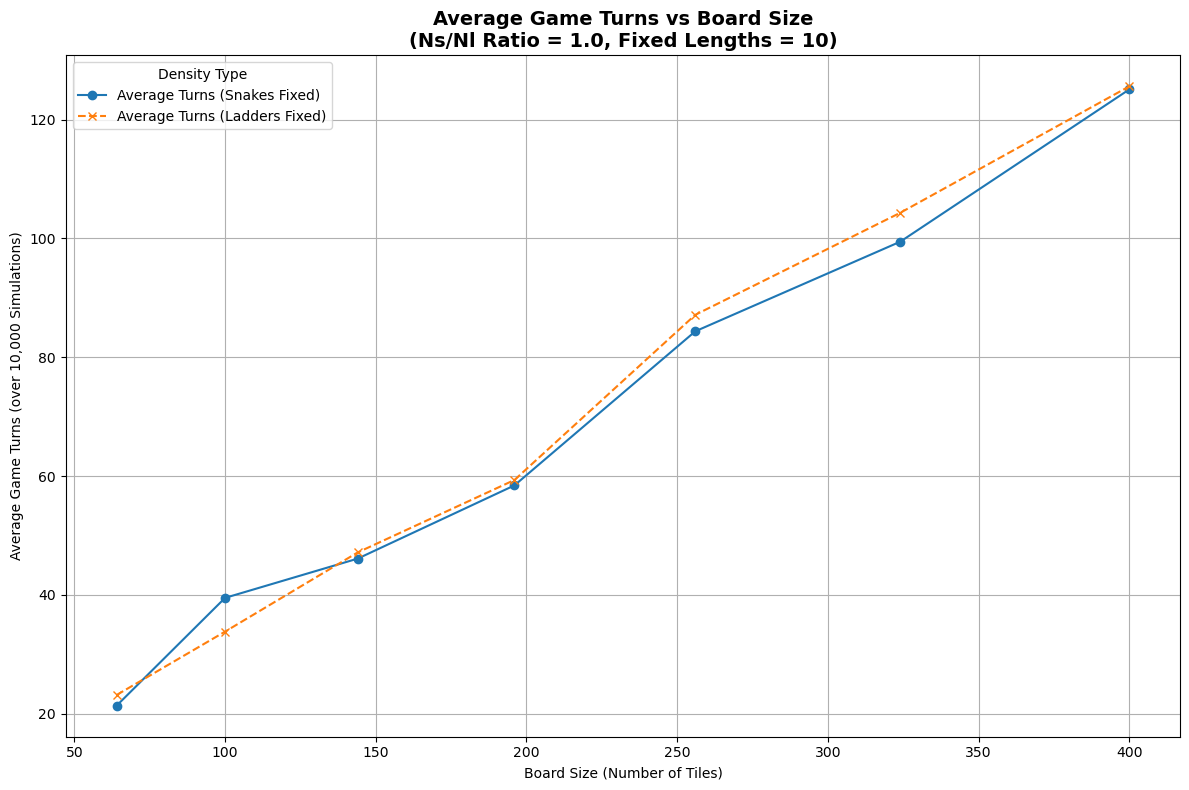

In [131]:
# Cell 25: Call plot_avg_turns_vs_board_size_ratio_one to generate the plot

plot_avg_turns_vs_board_size_ratio_one(results_df)

In [132]:
# Cell 27: Function to Plot Average Game Turns vs Ns/Nl Ratio (Combined Across Board Sizes)

def plot_avg_turns_vs_ratio_combined(results_df):
    """
    Plots Average Game Turns vs Ns/Nl Ratio, COMBINED across all board sizes,
    for both Fixed Snake and Fixed Ladder Density.
    """
    plt.figure(figsize=(12, 8))

    # --- Data for Fixed Snake Density (Aggregated across board sizes) ---
    snake_df_combined = results_df[results_df['simulation_type'] == "fixed_snake_density"].groupby('ns_nl_ratio')['average_turns'].mean().reset_index()

    # Plot Average Turns vs Ns/Nl Ratio (Fixed Snake Density, Combined)
    plt.plot(snake_df_combined['ns_nl_ratio'], snake_df_combined['average_turns'],
             marker='o', linestyle='-', label='Average Turns (Snakes Fixed)')


    # --- Data for Fixed Ladder Density (Aggregated across board sizes) ---
    ladder_df_combined = results_df[results_df['simulation_type'] == "fixed_ladder_density"].groupby('ns_nl_ratio')['average_turns'].mean().reset_index()

    # Plot Average Turns vs Ns/Nl Ratio (Fixed Ladder Density, Combined)
    plt.plot(ladder_df_combined['ns_nl_ratio'], ladder_df_combined['average_turns'],
             marker='x', linestyle='--', label='Average Turns (Ladders Fixed)')


    plt.xlabel("Ns/Nl Ratio (Number of Snakes / Number of Ladders)")
    plt.ylabel("Average Game Turns (Averaged across all Board Sizes, over 10,000 Simulations)") # Updated y-axis label
    plot_title = "Average Game Turns vs Ns/Nl Ratio\n(Aggregated across Board Sizes, Fixed Lengths = 10)" # Enhanced plot title
    plt.title(plot_title, fontsize=14, fontweight='bold') # More prominent title
    plt.legend(title="Density Type") # Legend title
    plt.grid(True)
    plt.tight_layout()

    # --- SAVE PLOT (Average Game Turns vs Ratio Combined) ---
    plot_params_avg_turns_combined_ratio = {} # No specific parameters needed for filename, as it's combined plot
    save_plot(plt, "AvgTurnsVsRatio_CombinedBoards", plot_params_avg_turns_combined_ratio) # Call save_plot


    plt.show() # Keep plt.show() OUTSIDE loops

Plot saved to: plots_output/AvgTurnsVsRatio_CombinedBoards/AvgTurnsVsRatio_CombinedBoards.png


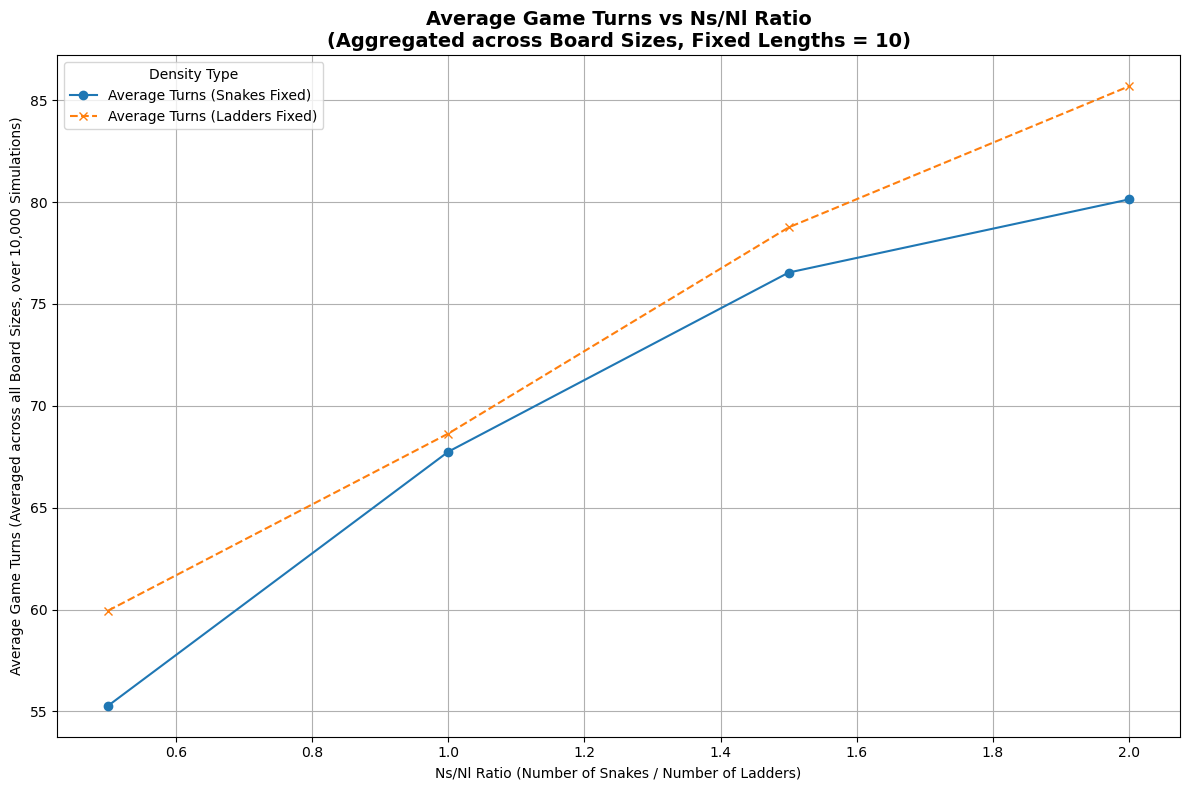

In [133]:
# Cell 28: Call plot_avg_turns_vs_ratio_combined to generate the plot

plot_avg_turns_vs_ratio_combined(results_df)


=== Entering plot_avg_turns_vs_ratio_with_errorbars function ===
Shape of results_df passed to plot_avg_turns_vs_ratio_with_errorbars: (56, 13)
Columns of results_df passed to plot_avg_turns_vs_ratio_with_errorbars: ['board_size', 'num_snakes', 'num_ladders', 'snake_ladder_ratio', 'average_turns', 'min_turns', 'max_turns', 'prob_win_half_turns', 'prob_win_third_turns', 'prob_win_quarter_turns', 'simulation_type', 'ns_nl_ratio', 'turn_counts']


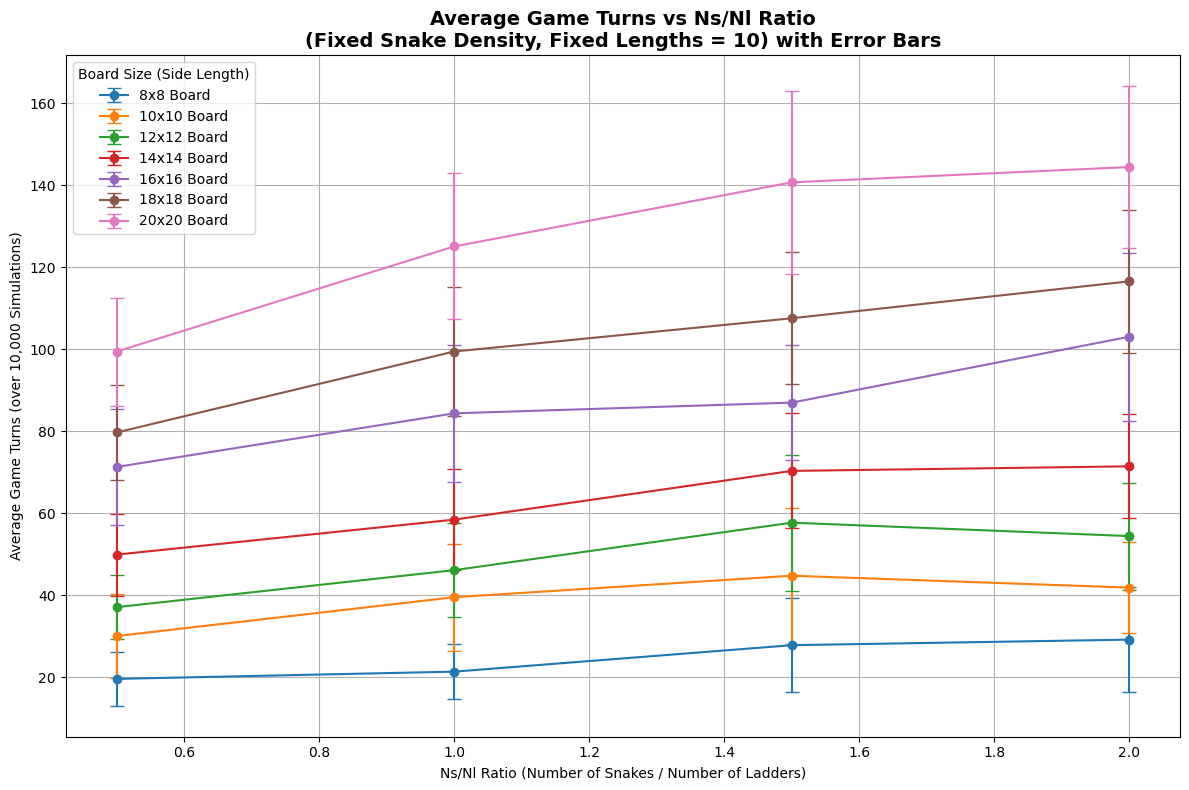

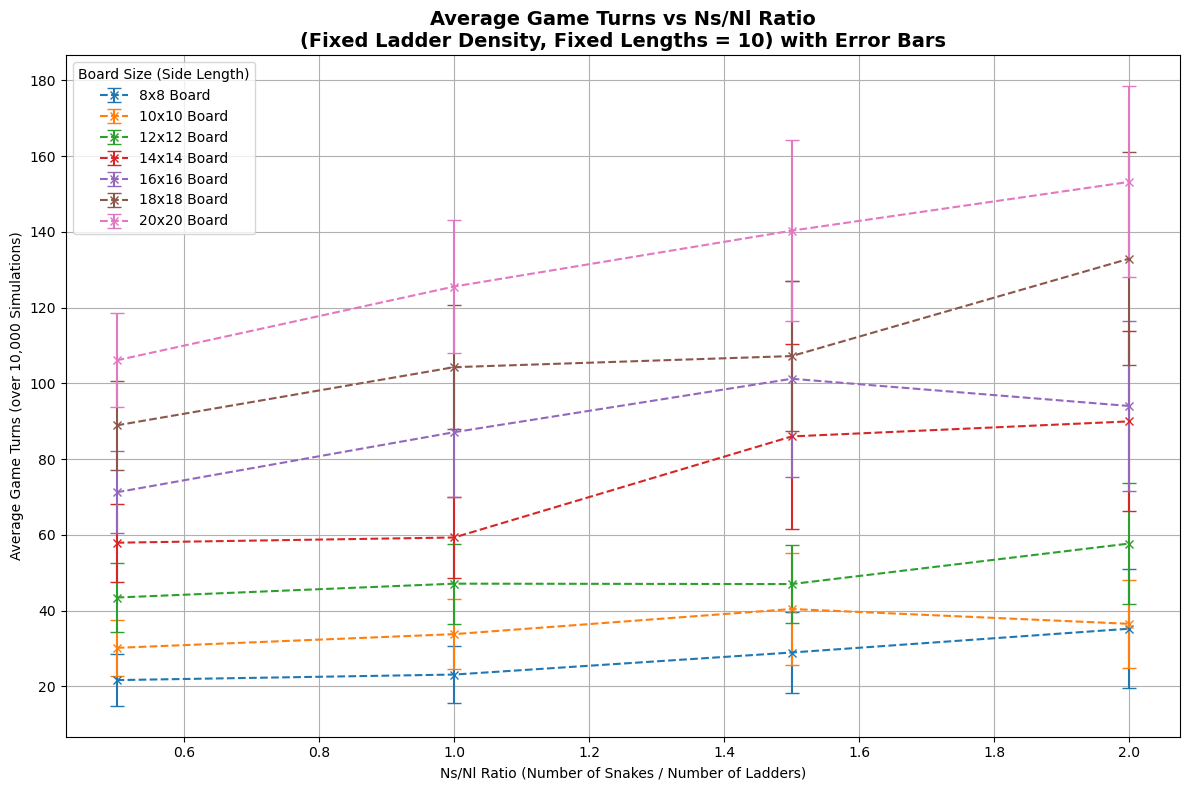

Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-0_5.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-1_0.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-1_5.png
Plot saved to: plots_output/WinProbVsBoardSize_ByRatio/WinProbVsBoardSize_ByRatio_ns_nl_ratio-2_0.png


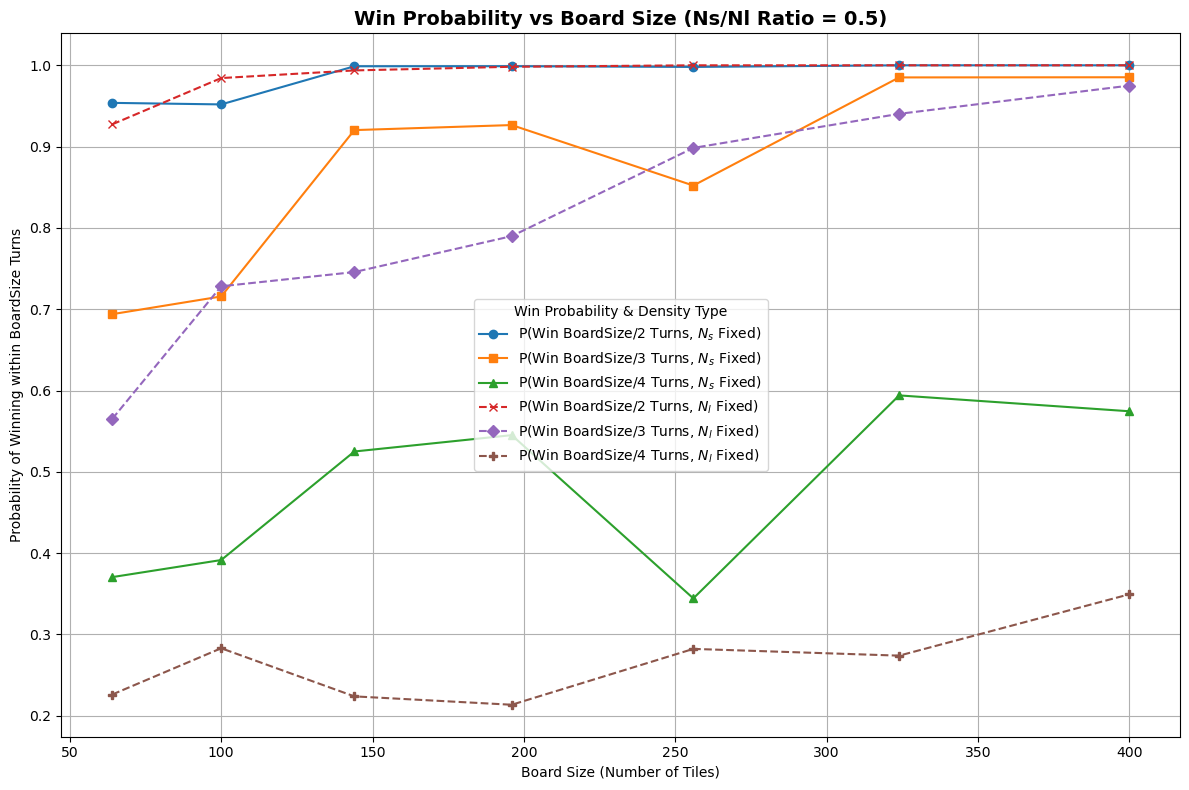

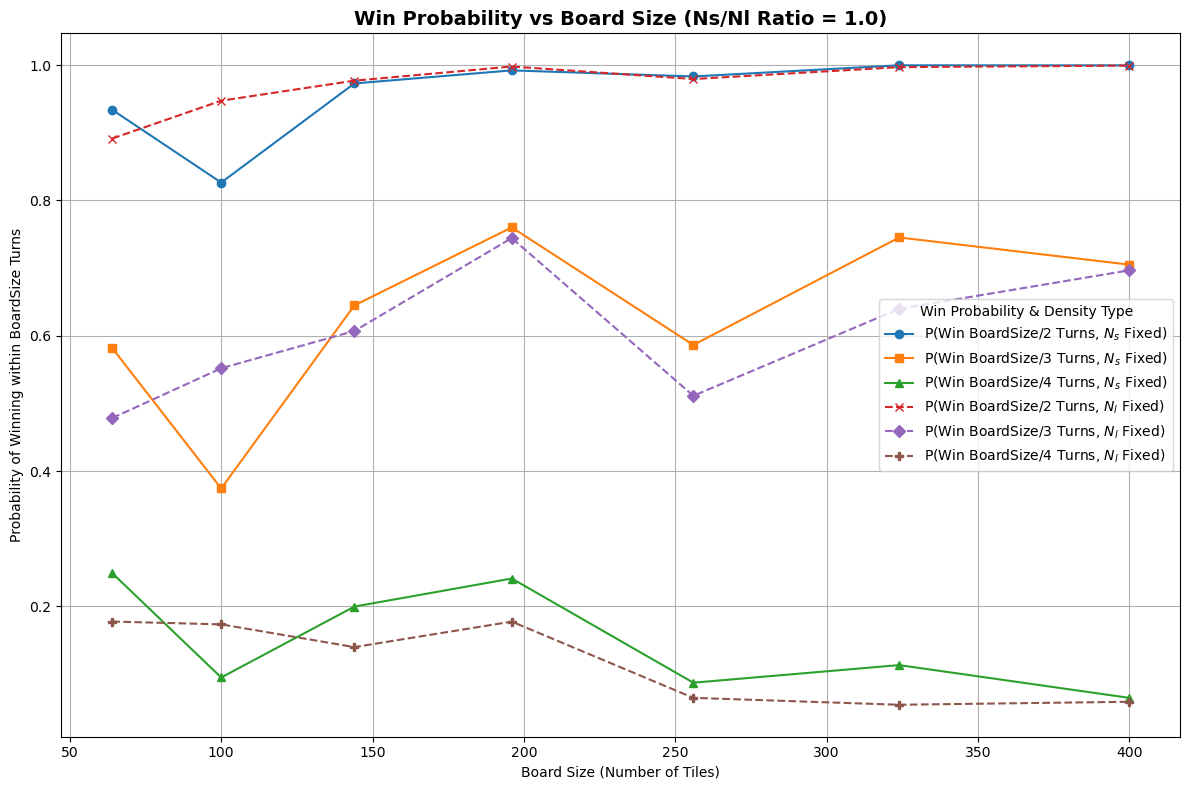

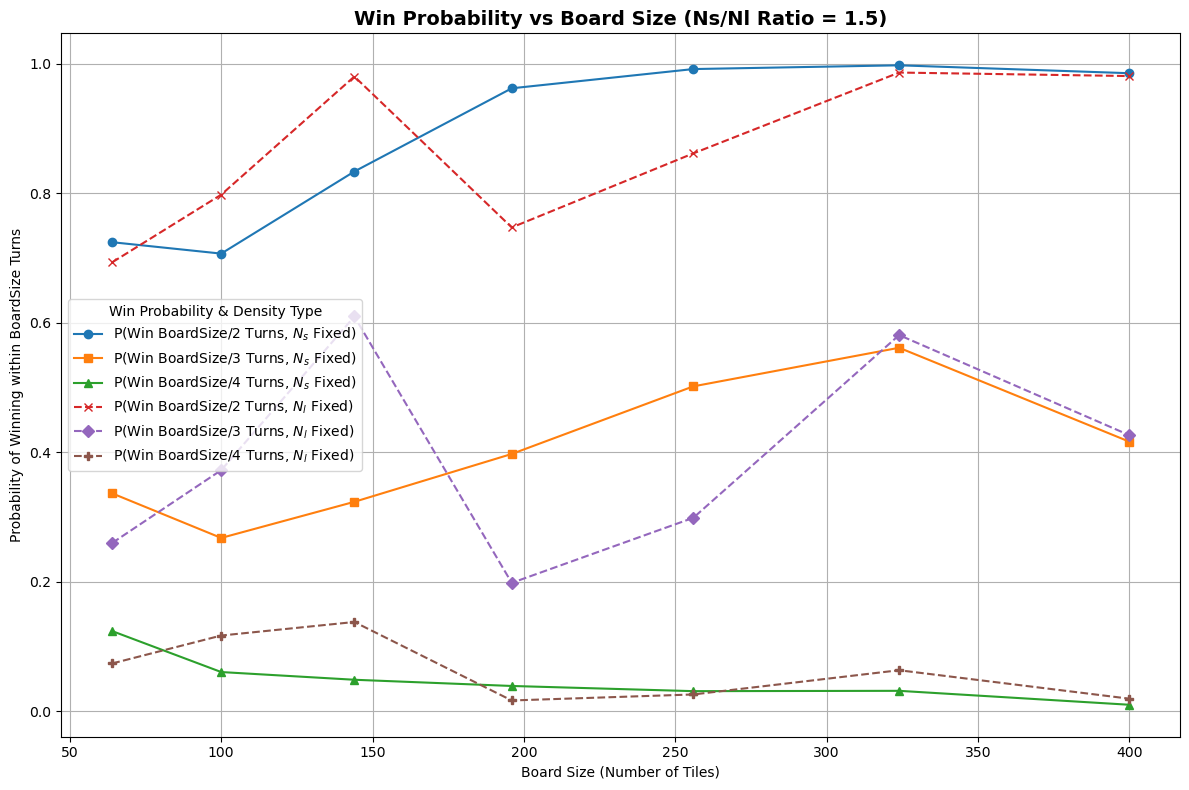

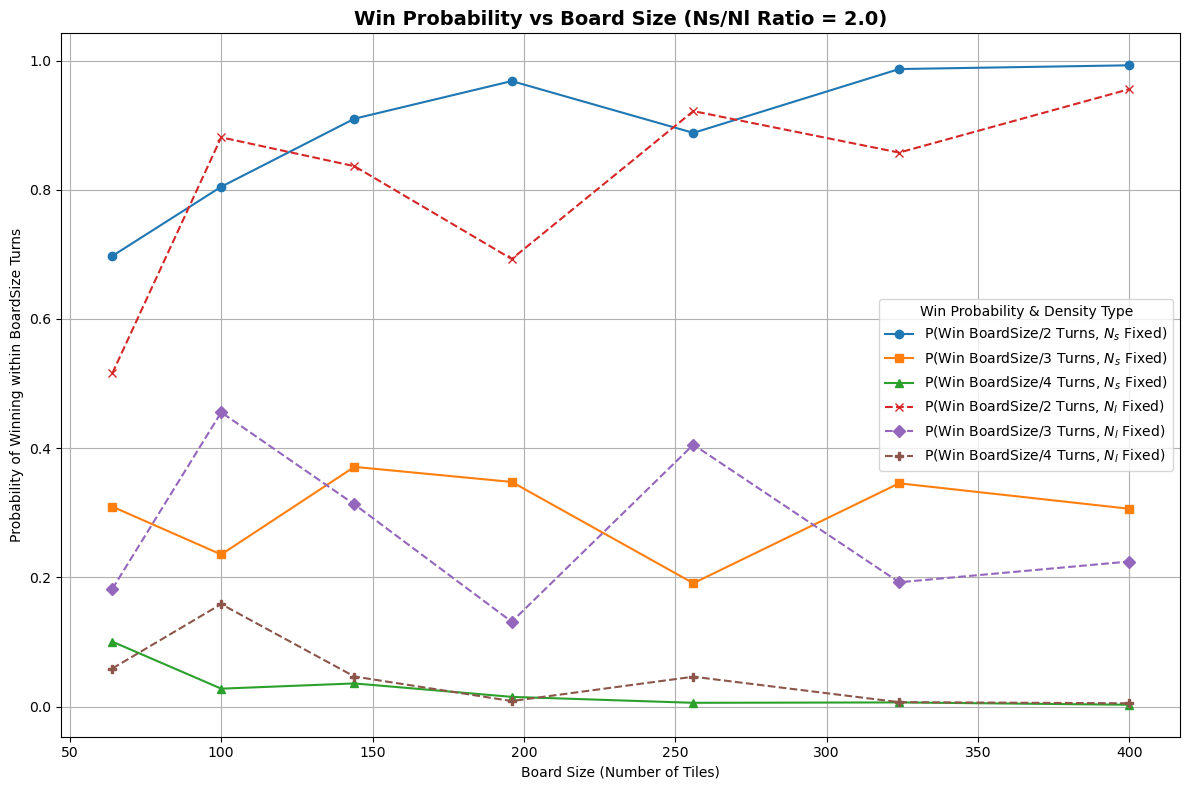

Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_half_turns_simulation_type-fixed_snake_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_third_turns_simulation_type-fixed_snake_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_quarter_turns_simulation_type-fixed_snake_density.png


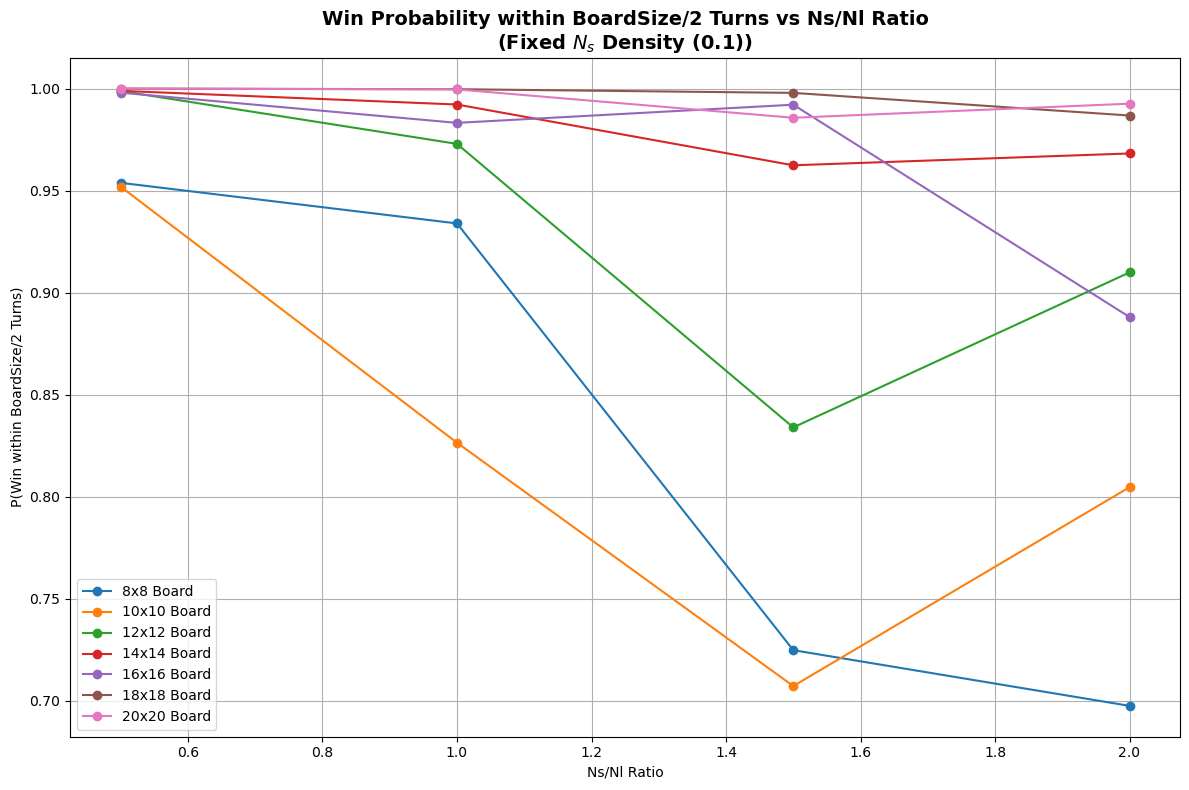

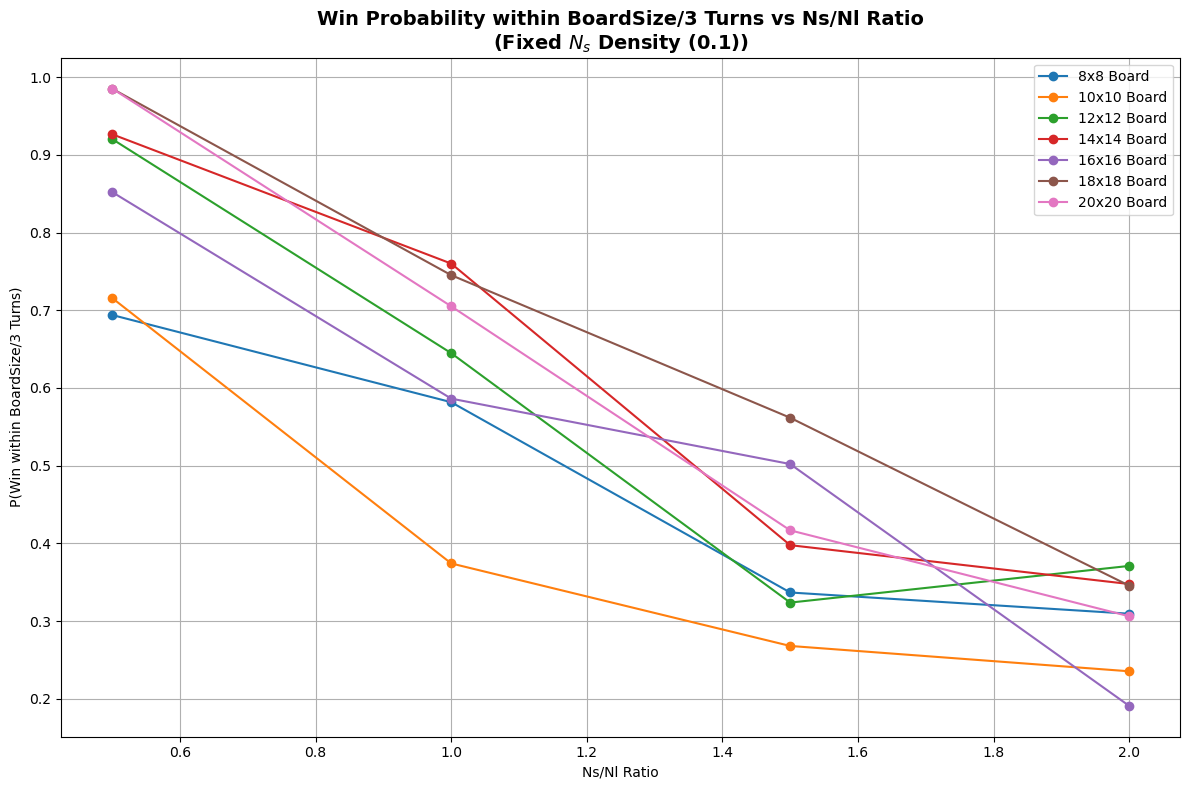

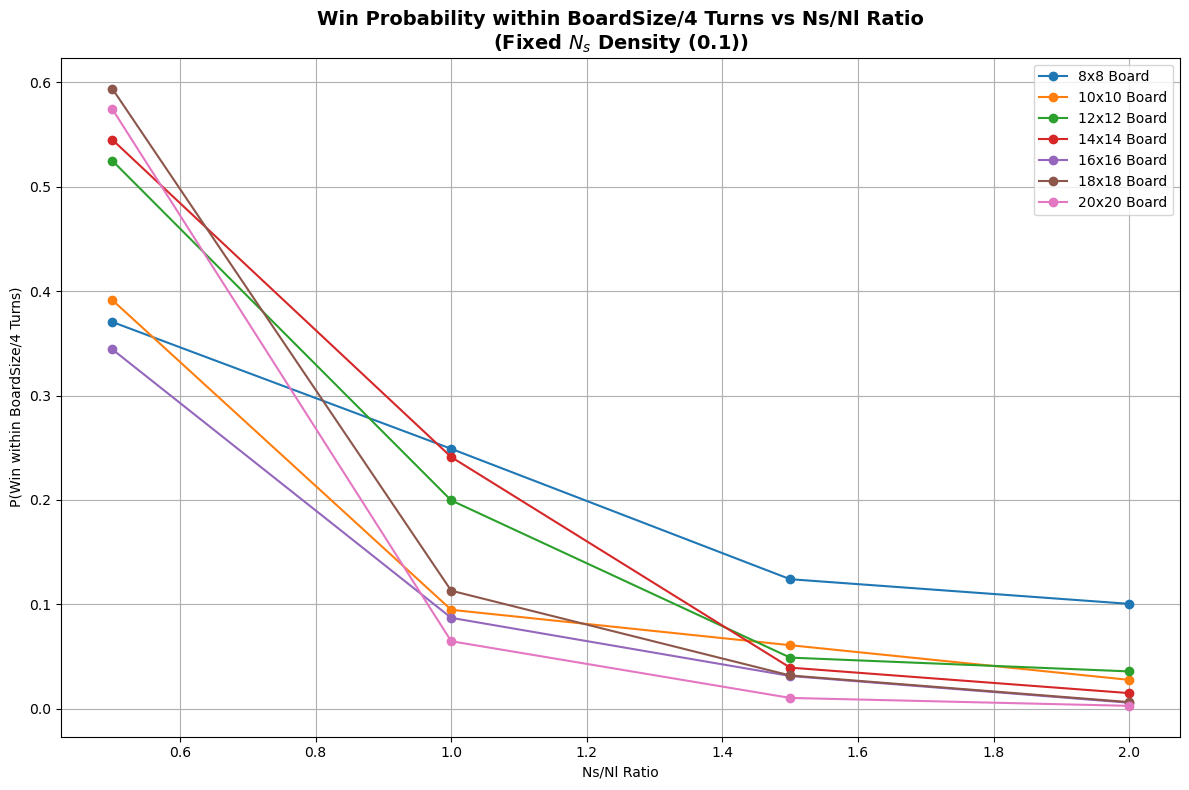

Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_half_turns_simulation_type-fixed_ladder_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_third_turns_simulation_type-fixed_ladder_density.png
Plot saved to: plots_output/WinProbVsRatio_Combined/WinProbVsRatio_Combined_prob_type-prob_win_quarter_turns_simulation_type-fixed_ladder_density.png


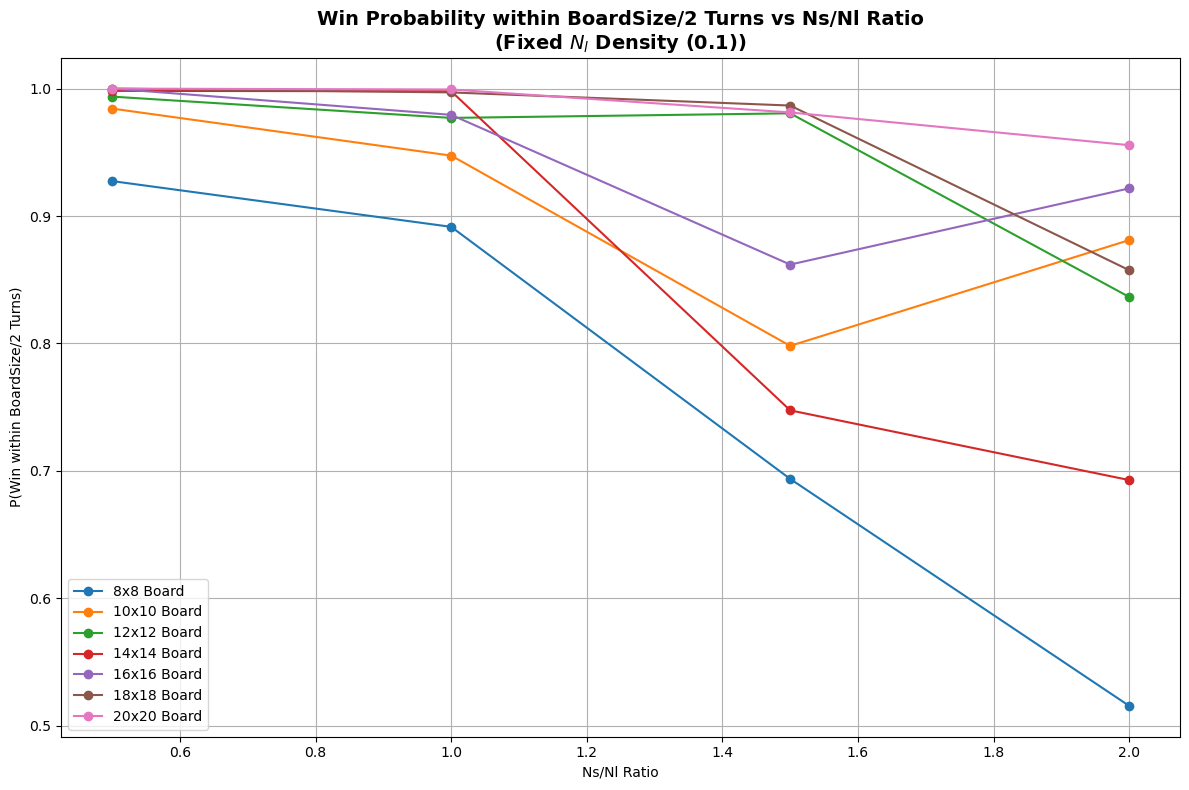

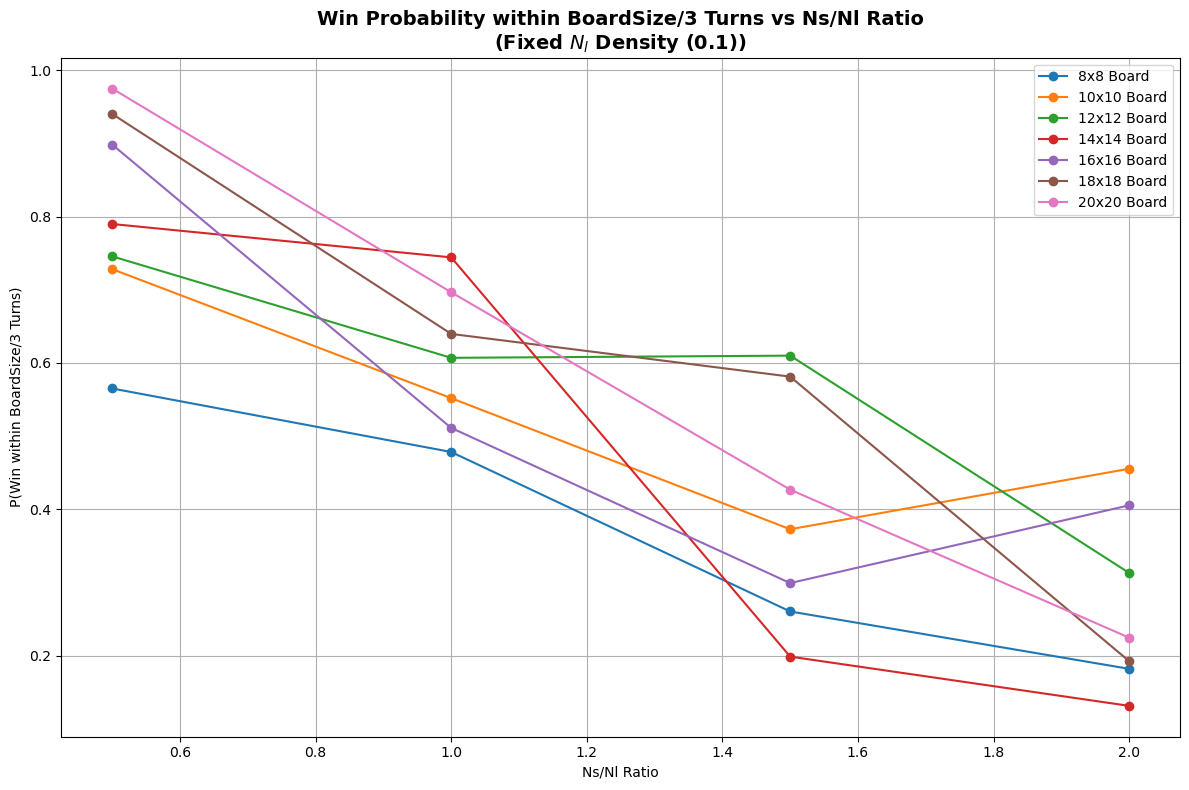

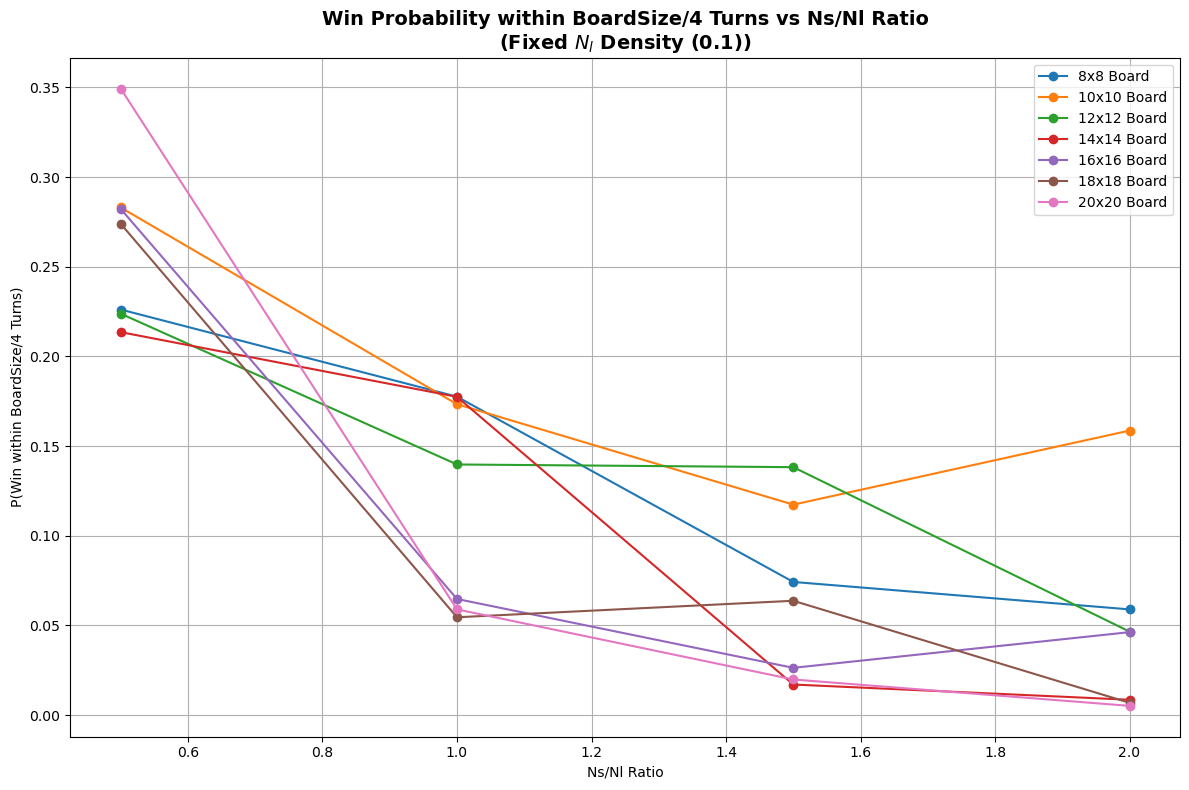

In [134]:
# Cell 16: Call plot_avg_turns_vs_ratio_with_errorbars to generate the plot (Re-run)

plot_avg_turns_vs_ratio_with_errorbars(results_df)

# Cell 18: Call plot_win_prob_vs_board_size_by_ratio to generate plots (Re-run)

plot_win_prob_vs_board_size_by_ratio(results_df)

# Cell 17: Call plot_win_probability_vs_ratio_combined to generate plots

plot_win_probability_vs_ratio_combined(results_df, "fixed_snake_density") # Example call for fixed_snake_density
plot_win_probability_vs_ratio_combined(results_df, "fixed_ladder_density") # Example call for fixed_ladder_density